## Setup

In [ ]:
# @title Include Packages

import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pandas as pd
import time

if "tqdm" not in locals():
  !pip3 install tqdm
  from tqdm import tqdm

if "torch" not in locals():
  !pip3 install torch
  import torch
  import torch.nn as nn
  import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
#@title Misc Functions
def permutation_matrix(indices):
  n = len(indices)
  matrix = torch.zeros((n, n), dtype=float)
  for i, idx in enumerate(indices):
      matrix[i, idx] = 1.0
  return matrix

In [ ]:
#@title A Factory for setting preset schema
class SchemaFactory(object):
  def __init__(self):
      pass

  def set_TRIPLE_DELTA(self, scheme):
    scheme.TRIPLE_DELTA_nmnddm = torch.einsum("ac,Ab,BC->cCaAbB", torch.eye(scheme.n), torch.eye(scheme.d), torch.eye(scheme.m)).type(torch.float64)

  def set_scheme(self, scheme, preset='random', **kwargs):
      if 'n' in kwargs: scheme.n = kwargs['n']
      elif scheme.n is None: scheme.n = 2
      if 'd' in kwargs: scheme.d = kwargs['d']
      elif scheme.d is None: scheme.d = scheme.n
      if 'm' in kwargs: scheme.m = kwargs['m']
      elif scheme.m is None: scheme.m = scheme.n
      if 'p' in kwargs: scheme.p = kwargs['p']
      elif scheme.p is None: scheme.p = scheme.n*scheme.d*scheme.m

      if 'fourier' in kwargs: preset = 'fourier'

      match preset:
        case 'random':   self.set_random(scheme)
        case 'complex':  self.set_random(scheme, norm=1, field='C')
        case 'naive':    self.set_naive(scheme)
        case 'fourier':
          self.set_naive(scheme, norm=1, field='C') # fourier level 0 makes a complex naive scheme
          self.Fourier(scheme, level=kwargs['fourier'])
        case 'strassen': self.set_Strassen(scheme)
        case 'winograd': self.set_Winograd(scheme)
        case 'laderman': self.set_Laderman(scheme)

  def set_random(self, scheme, Re_std_dev=1, Im_std_dev=1, norm=2, field='R'):
    scheme.alpha_pnd = torch.normal(0, Re_std_dev, size=(scheme.p, scheme.n, scheme.d)).type(torch.float64)
    scheme.beta__pdm = torch.normal(0, Re_std_dev, size=(scheme.p, scheme.d, scheme.m)).type(torch.float64)
    scheme.gamma_nmp = torch.normal(0, Re_std_dev, size=(scheme.n, scheme.m, scheme.p)).type(torch.float64)
    if field == 'C':
      scheme.alpha_pnd = scheme.alpha_pnd.type(torch.complex128) + torch.normal(0, Im_std_dev, size=(scheme.p, scheme.n, scheme.d)).type(torch.complex128)*1j
      scheme.beta__pdm = scheme.beta__pdm.type(torch.complex128) + torch.normal(0, Im_std_dev, size=(scheme.p, scheme.d, scheme.m)).type(torch.complex128)*1j
      scheme.gamma_nmp = scheme.gamma_nmp.type(torch.complex128) + torch.normal(0, Im_std_dev, size=(scheme.n, scheme.m, scheme.p)).type(torch.complex128)*1j
    SchemeManipulator().set_norm(scheme, norm=norm, field=field)
    self.set_TRIPLE_DELTA(scheme)

  def set_naive(self, scheme, norm=1, field='R'):
    scheme.p = scheme.n*scheme.d*scheme.m
    L = L_inv = torch.eye(scheme.n).type(torch.float64)
    M = M_inv = torch.eye(scheme.d).type(torch.float64)
    R = R_inv = torch.eye(scheme.m).type(torch.float64)
    b,c,a = torch.ones(scheme.n), torch.ones(scheme.d), torch.ones(scheme.m)
    scheme.alpha_pnd = torch.einsum("ia,i,   j,Ak,k->ijkaA", L_inv, b,        a, M,     c).reshape((scheme.p,scheme.n,scheme.d)).type(torch.float64)
    scheme.beta__pdm = torch.einsum(   "i,jB,j,kb,k->ijkbB",        b, R_inv, a, M_inv, c).reshape((scheme.p,scheme.d,scheme.m)).type(torch.float64)
    scheme.gamma_nmp = torch.einsum("ci,i,Cj,j,   k->cCijk", L,     b, R,     a,        c).reshape((scheme.n,scheme.m,scheme.p)).type(torch.float64)
    self.set_TRIPLE_DELTA(scheme)

  def Fourier(self, scheme, level=2, norm=1):
    if level <= 0: return # no Fourier
    import math

    scheme.alpha_pnd = scheme.alpha_pnd.type(torch.complex128)
    scheme.beta__pdm = scheme.beta__pdm.type(torch.complex128)
    scheme.gamma_nmp = scheme.gamma_nmp.type(torch.complex128)

    theta_n = 2 * 3.141592653589793238462643383279502884197j / scheme.n
    theta_d = 2 * 3.141592653589793238462643383279502884197j / scheme.d
    theta_m = 2 * 3.141592653589793238462643383279502884197j / scheme.m

    fourier_n = torch.pow(torch.full((scheme.n,), theta_n), torch.arange(scheme.n)).type(torch.complex128)
    fourier_d = torch.pow(torch.full((scheme.d,), theta_d), torch.arange(scheme.d)).type(torch.complex128)
    fourier_m = torch.pow(torch.full((scheme.m,), theta_m), torch.arange(scheme.m)).type(torch.complex128)

    vander_n = torch.vander(fourier_n, increasing=True).type(torch.complex128)
    vander_d = torch.vander(fourier_d, increasing=True).type(torch.complex128)
    vander_m = torch.vander(fourier_m, increasing=True).type(torch.complex128)

    # apply
    if level == 1: SchemeManipulator().change_basis(scheme, M=vander_d)
    elif level == 2: SchemeManipulator().change_basis(scheme, L=vander_n, R=vander_m, M=vander_d)
    # FIXME: apply a fourier transform along the product axis as well
    elif level >= 3: SchemeManipulator().change_basis(scheme, L=vander_n, R=vander_m, M=vander_d)
    self.set_TRIPLE_DELTA(scheme)

  def set_Strassen(self, scheme):
    scheme.n = scheme.d = scheme.m = 2
    scheme.p = 7
    scheme.alpha_pnd = torch.Tensor([[[ 1,0],[0, 1]],[[ 0,0],[1, 1]],[[ 1,0],[0, 0]],[[ 0,0],[0, 1]],[[ 1,1],[0, 0]],[[-1,0],[1, 0]],[[ 0,1],[0,-1]]]).type(torch.float64)
    scheme.beta__pdm  = torch.Tensor([[[ 1,0],[0, 1]],[[ 1,0],[0, 0]],[[ 0,1],[0,-1]],[[-1,0],[1, 0]],[[ 0,0],[0, 1]],[[ 1,1],[0, 0]],[[ 0,0],[1, 1]]]).type(torch.float64)
    scheme.gamma_nmp = torch.Tensor([[[1, 0,0,1,-1,0,1], [0, 0,1,0, 1,0,0]],[[0, 1,0,1, 0,0,0], [1,-1,1,0, 0,1,0]]]).type(torch.float64)
    SchemeManipulator().set_norm(scheme, norm=1, field='R')
    self.set_TRIPLE_DELTA(scheme)

  def set_Winograd(self, scheme):
    scheme.n = scheme.d = scheme.m = 2
    scheme.p = 7
    scheme.alpha_pnd = torch.Tensor([[[ 1,0],[ 0, 0]],[[ 0,1],[ 0, 0]],[[ 1,1],[-1,-1]],[[ 0,0],[ 0, 1]],[[-1,0],[ 1, 0]],[[ 0,0],[ 1, 1]],[[-1,0],[ 1, 1]]]).type(torch.float64)
    scheme.beta__pdm  = torch.Tensor([[[ 1, 0],[0, 0]],[[ 0, 0],[1, 0]],[[ 0, 0],[0, 1]],[[-1, 1],[1,-1]],[[ 0, 1],[0,-1]],[[-1, 1],[0, 0]],[[ 1,-1],[0, 1]]]).type(torch.float64)
    scheme.gamma_nmp = torch.Tensor([[[1,1,0,0,0,0,0], [1,0,1,0,0,1,1]],[[1,0,0,1,1,0,1], [1,0,0,0,1,1,1]]]).type(torch.float64)
    SchemeManipulator().set_norm(scheme, norm=1, field='R')
    self.set_TRIPLE_DELTA(scheme)

  def set_Laderman(self, scheme):
    scheme.n = scheme.d = scheme.m = 3
    scheme.p = 23
    scheme.alpha_pnd = torch.Tensor([[[ 1,1, 1],[-1,-1, 0],[ 0,-1,-1]],[[ 1,0, 0],[-1, 0, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 1, 0],[ 0, 0, 0]],[[-1,0, 0],[ 1, 1, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 1, 1, 0],[ 0, 0, 0]], # 5
                               [[ 1,0, 0],[ 0, 0, 0],[ 0, 0, 0]],[[-1,0, 0],[ 0, 0, 0],[ 1, 1, 0]],[[-1,0, 0],[ 0, 0, 0],[ 1, 0, 0]],[[ 0,0, 0],[ 0, 0, 0],[ 1, 1, 0]],[[ 1,1, 1],[ 0,-1,-1],[-1,-1, 0]], # 10
                               [[ 0,0, 0],[ 0, 0, 0],[ 0, 1, 0]],[[ 0,0,-1],[ 0, 0, 0],[ 0, 1, 1]],[[ 0,0, 1],[ 0, 0, 0],[ 0, 0,-1]],[[ 0,0, 1],[ 0, 0, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 0, 0],[ 0, 1, 1]], # 15
                               [[ 0,0,-1],[ 0, 1, 1],[ 0, 0, 0]],[[ 0,0, 1],[ 0, 0,-1],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 1, 1],[ 0, 0, 0]],[[ 0,1, 0],[ 0, 0, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 0, 1],[ 0, 0, 0]], # 20
                               [[ 0,0, 0],[ 1, 0, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 0, 0],[ 1, 0, 0]],[[ 0,0, 0],[ 0, 0, 0],[ 0, 0, 1]]]).type(torch.float64)
    scheme.beta__pdm  = torch.Tensor([[[ 0, 0, 0],[0, 1, 0],[ 0, 0, 0]],[[ 0,-1, 0],[0, 1, 0],[ 0, 0, 0]],[[-1, 1, 0],[1,-1,-1],[-1, 0, 1]],[[ 1,-1, 0],[0, 1, 0],[ 0, 0, 0]],[[-1, 1, 0],[0, 0, 0],[ 0, 0, 0]], # 5
                               [[ 1, 0, 0],[0, 0, 0],[ 0, 0, 0]],[[ 1, 0,-1],[0, 0, 1],[ 0, 0, 0]],[[ 0, 0, 1],[0, 0,-1],[ 0, 0, 0]],[[-1, 0, 1],[0, 0, 0],[ 0, 0, 0]],[[ 0, 0, 0],[0, 0, 1],[ 0, 0, 0]], # 10
                               [[-1, 0, 1],[1,-1,-1],[-1, 1, 0]],[[ 0, 0, 0],[0, 1, 0],[ 1,-1, 0]],[[ 0, 0, 0],[0, 1, 0],[ 0,-1, 0]],[[ 0, 0, 0],[0, 0, 0],[ 1, 0, 0]],[[ 0, 0, 0],[0, 0, 0],[-1, 1, 0]], # 15
                               [[ 0, 0, 0],[0, 0, 1],[ 1, 0,-1]],[[ 0, 0, 0],[0, 0, 1],[ 0, 0,-1]],[[ 0, 0, 0],[0, 0, 0],[-1, 0, 1]],[[ 0, 0, 0],[1, 0, 0],[ 0, 0, 0]],[[ 0, 0, 0],[0, 0, 0],[ 0, 1, 0]], # 20
                               [[ 0, 0, 1],[0, 0, 0],[ 0, 0, 0]],[[ 0, 1, 0],[0, 0, 0],[ 0, 0, 0]],[[ 0, 0, 0],[0, 0, 0],[ 0, 0, 1]]]).type(torch.float64)
    scheme.gamma_nmp = torch.Tensor([[[0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0], [1,0,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0], [0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0]],
                               [[0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0], [0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0]],
                               [[0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0], [0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]]).type(torch.float64)
    SchemeManipulator().set_norm(scheme, norm=1, field='R')#15        20                  5        10        15        20                  5        10        15        20
    self.set_TRIPLE_DELTA(scheme)

  def read_from_files(self, scheme, n=None, d=None, m=None, p=None, number=None, filename=None, verbose=0):
    if filename is None:
      if n is None and p is None and number is not None:
        filename = f'{float(number):.3f}'
      elif n is not None and d is not None and m is not None and p is not None and number is not None:
        filename = f'{n}_{d}_{m}_{p}_e{float(number):.3f}'
      else:
        print('must provide a file header, number, or scheme sizes')
    import pickle
    file1 = open(f'{filename}_alpha_pnd.pkl', 'rb')
    alpha_pnd = pickle.load(file1)
    file1.close()
    file1 = open(f'{filename}_beta__pdm.pkl', 'rb')
    beta__pdm = pickle.load(file1)
    file1.close()
    file1 = open(f'{filename}_gamma_nmp.pkl', 'rb')
    gamma_nmp = pickle.load(file1)
    file1.close()

    SchemeManipulator().set(scheme, alpha_pnd, beta__pdm, gamma_nmp)
    self.set_TRIPLE_DELTA(scheme)
    if verbose > 0: SchemeDisplay().print(scheme, verbose=verbose)

  def compose_schemes(self, outer, inner): # cCaAbBi, zZxXyY
    result = BrentScheme()
    result.n = outer.n * inner.n
    result.d = outer.d * inner.d
    result.m = outer.m * inner.m
    result.p = outer.p * inner.p
    SchemaFactory().set_TRIPLE_DELTA(result)
    result.gamma_nmp = torch.einsum('cCi,zZj->czCZij', outer.gamma_nmp, inner.gamma_nmp).reshape((result.n, result.m, result.p))
    result.alpha_pnd = torch.einsum('iaA,jxX->ijaxAX', outer.alpha_pnd, inner.alpha_pnd).reshape((result.p, result.n, result.d))
    result.beta__pdm = torch.einsum('ibB,jyY->ijbyBY', outer.beta__pdm, inner.beta__pdm).reshape((result.p, result.d, result.m))
    return result

factory = SchemaFactory()

In [ ]:
# @title A Manipulation object for an existing scheme
class SchemeManipulator(object):

  def __init__(self):
    pass

  # set the member tensors manually
  def set(self, scheme, alpha_pnd, beta__pdm, gamma_nmp, norm=1):
    scheme.p = alpha_pnd.shape[0]
    scheme.n = alpha_pnd.shape[1]
    scheme.d = alpha_pnd.shape[2]
    scheme.m = gamma_nmp.shape[1]

    scheme.alpha_pnd = alpha_pnd
    scheme.beta__pdm = beta__pdm
    scheme.gamma_nmp = gamma_nmp

    self.set_norm(scheme, norm=norm)
    SchemaFactory().set_TRIPLE_DELTA(scheme)

  # change the norm or feild of the scheme (L1, L2, etc, R, C)
  def set_norm(self, scheme, norm=1, field=None):
    scheme.L_norm = norm

    if "field" not in scheme.__dict__:
      scheme.field = 'R'
      if scheme.alpha_pnd.dtype == torch.complex128 or scheme.beta__pdm == torch.complex128 or scheme.gamma_nmp == torch.complex128: field = 'C'
    else: scheme.field = field

    if scheme.field == 'R':
      scheme.alpha_pnd = torch.real(scheme.alpha_pnd).type(torch.float64)
      scheme.beta__pdm = torch.real(scheme.beta__pdm).type(torch.float64)
      scheme.gamma_nmp = torch.real(scheme.gamma_nmp).type(torch.float64)
    elif scheme.field == 'C':
      scheme.alpha_pnd = scheme.alpha_pnd.type(torch.complex128)
      scheme.beta__pdm = scheme.beta__pdm.type(torch.complex128)
      scheme.gamma_nmp = scheme.gamma_nmp.type(torch.complex128)

    if norm < 1:
      print(f"THE L{norm} NORM IS NOT SUPPORTED: TRY [1,inf]")
    elif norm == torch.inf:
      scheme.norm = lambda x : torch.max(torch.abs(x))
      scheme.inv_norm = lambda x : x
    elif norm == 1: # specialize for speedup
      scheme.norm = lambda x : torch.sum(torch.abs(x))
      scheme.inv_norm = lambda x : x # a norm should be F -> R, so this is ok
    else:
      scheme.norm = lambda x : torch.sum(torch.abs(x)**norm)
      scheme.inv_norm = lambda x : x**(1.0/norm) # a norm should be F -> R, so this is ok

  ### CLEAN UP AN EXISTING SCHEME ###

  # enforce that alpha and beta have normalized components along p, using current or passed norm
  def normalize(self, scheme, verbose=0):
    if verbose > 1: SchemeDisplay().print(scheme)
    self.clean(scheme) # get rid of zero-norm products

    # make the matrix basis have balanced axis norms

    # L basis
    if scheme.L_norm == np.inf:
      alpha_mags_n = torch.from_numpy(np.array([torch.max(torch.abs(scheme.alpha_pnd[:,ni,:])) for ni in range(scheme.n)]))
      gamma_mags_n = torch.from_numpy(np.array([torch.max(torch.abs(scheme.gamma_nmp[ni,:,:])) for ni in range(scheme.n)]))
    else:
      alpha_mags_n = torch.einsum("pnd->n", torch.abs(scheme.alpha_pnd)**scheme.L_norm)**(1/scheme.L_norm)
      gamma_mags_n = torch.einsum("nmp->n", torch.abs(scheme.gamma_nmp)**scheme.L_norm)**(1/scheme.L_norm)

    avg_mags_n = (alpha_mags_n * gamma_mags_n)**(1/2)
    avg_mags_n, permutation_n = torch.sort(avg_mags_n, descending=True)
    scheme.alpha_pnd = scheme.alpha_pnd[:,permutation_n,:] / alpha_mags_n[permutation_n].reshape(1,-1,1) * avg_mags_n.reshape(1,-1,1)
    scheme.gamma_nmp = scheme.gamma_nmp[permutation_n,:,:] / gamma_mags_n[permutation_n].reshape(-1,1,1) * avg_mags_n.reshape(-1,1,1)

    if verbose > 0: print("new n magnitudes: ", avg_mags_n)

    # M basis
    if scheme.L_norm == np.inf:
      alpha_mags_d = torch.from_numpy(np.array([torch.max(torch.abs(scheme.alpha_pnd[:,:,di])) for di in range(scheme.d)]))
      beta__mags_d = torch.from_numpy(np.array([torch.max(torch.abs(scheme.beta__pdm[:,di,:])) for di in range(scheme.d)]))
    else:
      alpha_mags_d = torch.einsum("pnd->d", torch.abs(scheme.alpha_pnd)**scheme.L_norm)**(1/scheme.L_norm)
      beta__mags_d = torch.einsum("pdm->d", torch.abs(scheme.beta__pdm)**scheme.L_norm)**(1/scheme.L_norm)

    avg_mags_d = (alpha_mags_d * beta__mags_d)**(1/2)
    avg_mags_d, permutation_d = torch.sort(avg_mags_d, descending=True)
    scheme.alpha_pnd = scheme.alpha_pnd[:,:,permutation_d] / alpha_mags_d[permutation_d].reshape(1,1,-1) * avg_mags_d.reshape(1,1,-1)
    scheme.beta__pdm = scheme.beta__pdm[:,permutation_d,:] / beta__mags_d[permutation_d].reshape(1,-1,1) * avg_mags_d.reshape(1,-1,1)

    if verbose > 0: print("new d magnitudes: ", avg_mags_d)

    # R basis
    if scheme.L_norm == np.inf:
      beta__mags_m = torch.from_numpy(np.array([torch.max(torch.abs(scheme.beta__pdm[:,:,mi])) for mi in range(scheme.m)]))
      gamma_mags_m = torch.from_numpy(np.array([torch.max(torch.abs(scheme.gamma_nmp[:,mi,:])) for mi in range(scheme.m)]))
    else:
      beta__mags_m = torch.einsum("pdm->m", torch.abs(scheme.beta__pdm)**scheme.L_norm)**(1/scheme.L_norm)
      gamma_mags_m = torch.einsum("nmp->m", torch.abs(scheme.gamma_nmp)**scheme.L_norm)**(1/scheme.L_norm)

    avg_mags_m = (beta__mags_m * gamma_mags_m)**(1/2)
    avg_mags_m, permutation_m = torch.sort(avg_mags_m, descending=True)
    scheme.beta__pdm = scheme.beta__pdm[:,:,permutation_m] / beta__mags_m[permutation_m].reshape(1,1,-1) * avg_mags_m.reshape(1,1,-1)
    scheme.gamma_nmp = scheme.gamma_nmp[:,permutation_m,:] / gamma_mags_m[permutation_m].reshape(1,-1,1) * avg_mags_m.reshape(1,-1,1)

    if verbose > 0: print("new m magnitudes: ", avg_mags_m)

    # make the products of equal norms

    if scheme.L_norm == np.inf:
      alpha_mags_p = torch.from_numpy(np.array([torch.max(torch.abs(scheme.alpha_pnd[pi,:,:])) for pi in range(scheme.p)]))
      beta__mags_p = torch.from_numpy(np.array([torch.max(torch.abs(scheme.beta__pdm[pi,:,:])) for pi in range(scheme.p)]))
      gamma_mags_p = torch.from_numpy(np.array([torch.max(torch.abs(scheme.gamma_nmp[:,:,pi])) for pi in range(scheme.p)]))
    else:
      alpha_mags_p = torch.einsum("pnd->p", torch.abs(scheme.alpha_pnd)**scheme.L_norm)**(1/scheme.L_norm)
      beta__mags_p = torch.einsum("pdm->p", torch.abs(scheme.beta__pdm)**scheme.L_norm)**(1/scheme.L_norm)
      gamma_mags_p = torch.einsum("nmp->p", torch.abs(scheme.gamma_nmp)**scheme.L_norm)**(1/scheme.L_norm)

    avg_mags_p = (alpha_mags_p * beta__mags_p * gamma_mags_p)**(1/3)
    avg_mags_p, permutation_p = torch.sort(avg_mags_p, descending=True)
    scheme.alpha_pnd = scheme.alpha_pnd[permutation_p,:,:] / alpha_mags_p[permutation_p].reshape(-1,1,1) * avg_mags_p.reshape(-1,1,1)
    scheme.beta__pdm = scheme.beta__pdm[permutation_p,:,:] / beta__mags_p[permutation_p].reshape(-1,1,1) * avg_mags_p.reshape(-1,1,1)
    scheme.gamma_nmp = scheme.gamma_nmp[:,:,permutation_p] / gamma_mags_p[permutation_p].reshape(1,1,-1) * avg_mags_p.reshape(1,1,-1)

    if verbose > 0: print("new product magnitudes: ", avg_mags_p)

  # if the tensors have a zero magnitude in a p-axis cross section, drop that p index
  def clean(self, scheme):
    for prod in range(scheme.p-1, -1, -1):
      if scheme.norm(scheme.alpha_pnd[prod,:,:]) == 0 or scheme.norm(scheme.beta__pdm[prod,:,:]) == 0 or scheme.norm(scheme.gamma_nmp[:,:,prod]) == 0:
         self.drop_product(scheme, prod=prod+1)

  ### MANUALLY MUTATE AN EXISTING SCHEME ###

  # rounds each coefficient to a certian significant place
  def round(self, scheme, sig_figs=15):
    scheme.alpha_pnd = scheme.alpha_pnd.round(decimals=sig_figs)
    scheme.beta__pdm  = scheme.beta__pdm.round(decimals=sig_figs)
    scheme.gamma_nmp = scheme.gamma_nmp.round(decimals=sig_figs)

  # adds random noise to the scheme's coefficients
  def add_noise(self, scheme, epsilon=10**-15):
    scheme.alpha_pnd += torch.normal(0, epsilon, size=(scheme.p, scheme.n, scheme.d)).type(torch.float64)
    scheme.beta__pdm += torch.normal(0, epsilon, size=(scheme.p, scheme.d, scheme.m)).type(torch.float64)
    scheme.gamma_nmp += torch.normal(0, epsilon, size=(scheme.n, scheme.m, scheme.p)).type(torch.float64)

  # drops the least significant product from the central sum over p
  def chop(self, scheme, num=0, verbose=0):
    for i in range(num):
      gamma_scores_p = torch.einsum("nmp->p", torch.abs(scheme.gamma_nmp)) #FIXME: max along cross section at _p
      if verbose > 1: print(f"The gamma 2-tensors associated with each product have magnitudes: {gamma_scores_p}")
      _g = torch.argmin(gamma_scores_p)
      if verbose > 1: print(f"Dropping the product with magnitude: {gamma_scores_p[_g]}")
      self.drop_product(scheme, prod=_g+1, verbose=verbose)

  # scales the num_zeros_enforced smallest coefficients by decay_factor
  def enforce_zero_num(self, scheme, num_zeros_enforced=[0,0,0], decay_factor=0.7):
    for array_i, curr_zeros in enumerate(num_zeros_enforced):
      if curr_zeros == 0: continue
      array = [scheme.alpha_pnd, scheme.beta__pdm, scheme.gamma_nmp][array_i]
      elem_mag_to_set,_ = torch.sort(torch.abs(array).flatten())
      elem_mag_to_set = elem_mag_to_set[curr_zeros]
      array[torch.where(torch.abs(array)<=elem_mag_to_set)] = 0.0

  ### MAKE A SMALLER SCHEME ###

  # drop rows or columns from the scheme to reduce n,d,m dimentions
  def reduce_matrices(self, scheme, axes=[[],[],[]]):
    for i in range(3):
      if axes[i] is None:
        axes[i] = []
      elif isinstance(axes[i], int):
        axes[i] = [axes[i]]
      axes[i].sort(reverse=True)

    for _n in axes[0]:
      scheme.gamma_nmp = torch.concatenate((scheme.gamma_nmp[:_n,:,:], scheme.gamma_nmp[_n+1:,:,:]), axis=0)
      scheme.alpha_pnd = torch.concatenate((scheme.alpha_pnd[:,:_n,:], scheme.alpha_pnd[:,_n+1:,:]), axis=1)
    for _d in axes[1]:
      scheme.alpha_pnd = torch.concatenate((scheme.alpha_pnd[:,:,:_d], scheme.alpha_pnd[:,:,_d+1:]), axis=2)
      scheme.beta__pdm = torch.concatenate((scheme.beta__pdm[:,:_d,:], scheme.beta__pdm[:,_d+1:,:]), axis=1)
    for _m in axes[2]:
      scheme.beta__pdm = torch.concatenate((scheme.beta__pdm[:,:,:_m], scheme.beta__pdm[:,:,_m+1:]), axis=2)
      scheme.gamma_nmp = torch.concatenate((scheme.gamma_nmp[:,:_m,:], scheme.gamma_nmp[:,_m+1:,:]), axis=1)

    scheme.n -= len(axes[0])
    scheme.d -= len(axes[1])
    scheme.m -= len(axes[2])
    SchemaFactory().set_TRIPLE_DELTA(scheme)

  # drops the indicated product P_prod (int)
  def drop_product(self, scheme, prod=None, verbose=0):
    if prod is None: return
    prod -= 1 # UI is 1-indexed, tensor is 0-indexed
    scheme.alpha_pnd = torch.concatenate((scheme.alpha_pnd[:prod,:,:], scheme.alpha_pnd[prod+1:,:,:]), axis=0)
    scheme.beta__pdm = torch.concatenate((scheme.beta__pdm[:prod,:,:], scheme.beta__pdm[prod+1:,:,:]), axis=0)
    scheme.gamma_nmp = torch.concatenate((scheme.gamma_nmp[:,:,:prod], scheme.gamma_nmp[:,:,prod+1:]), axis=2)

    scheme.p = scheme.p - 1
    if verbose > 0: print(f'p is now: {scheme.p}')

  ### CHANGING AXES BASES ###

  # change of basis on n,d,m axes - uses normal matrix multiplication bases
  def change_basis(self, scheme, L=None, M=None, R=None):
    # works best with well-conditioned matrices and vectors close to ones().
    # basis change is: (L)C(R) = (L)A(M)(M_inv)B(R)
    # where the new scheme uses C' = (L)C(R), A' = (L)A(M), and B' = (M_inv)B(R)

    # L is shape nN, M is shape Dd, R is shape Mm (capitals are new, small axis, lowercase are the old, larger size/invertable axis)
    # L is left invertable, R is right invertable, M is right invertable

    if L is None: L = torch.eye(scheme.n)
    if M is None: M = torch.eye(scheme.d)
    if R is None: R = torch.eye(scheme.m)

    scheme.field = 'R'
    new_type = torch.float64
    if scheme.alpha_pnd.dtype == torch.complex128 or scheme.beta__pdm == torch.complex128 or scheme.gamma_nmp == torch.complex128 or \
    L.dtype == torch.complex128 or M.dtype == torch.complex128 or R.dtype == torch.complex128:
      scheme.field = 'C'
      new_type = torch.complex128

    scheme.alpha_pnd = scheme.alpha_pnd.type(new_type)
    scheme.beta__pdm = scheme.beta__pdm.type(new_type)
    scheme.gamma_nmp = scheme.gamma_nmp.type(new_type)

    L = L.type(new_type)
    R = R.type(new_type)
    M = M.type(new_type)

    L_inv = torch.linalg.pinv(L)
    R_inv = torch.linalg.pinv(R)
    M_inv = torch.linalg.pinv(M)

    scheme.alpha_pnd = torch.einsum("nN,Dd,pnd->pND", L,            M    , scheme.alpha_pnd).type(new_type)
    scheme.beta__pdm = torch.einsum("Mm,dD,pdm->pDM",        R,     M_inv, scheme.beta__pdm).type(new_type)
    scheme.gamma_nmp = torch.einsum("Nn,mM,nmp->NMp", L_inv, R_inv,        scheme.gamma_nmp).type(new_type)

    scheme.n = scheme.alpha_pnd.size(dim=1)
    scheme.d = scheme.alpha_pnd.size(dim=2)
    scheme.m = scheme.gamma_nmp.size(dim=1)
    scheme.p = scheme.alpha_pnd.size(dim=0)
    factory.set_TRIPLE_DELTA(scheme)

    self.set_norm(scheme, norm=scheme.L_norm, field=scheme.field)

  # insert a ones vector along the p-axis sum and decompose it arbirarily
  def scale_products(self, scheme, a, b):
    a = torch.Tensor(a)
    b = torch.Tensor(b)
    scheme.alpha_pnd = torch.einsum("pnd,p->pnd", scheme.alpha_pnd, a)
    scheme.beta__pdm = torch.einsum("pdm,p->pdm", scheme.beta__pdm, b)
    scheme.gamma_nmp = torch.einsum("nmp,p,p->nmp", scheme.gamma_nmp, 1/a, 1/b)

  def permute_products(self, scheme, permutation=None, verbose=0):
    if permutation is None: return # clustering not implemented in PyTorch colab
    #   gamma, products = scheme.flatten()
    #   u,_,__ = torch.linalg.svd(products)
    #   permutation = find_row_clustering(u, verbose=verbose)

    permutation = permutation_matrix(permutation)
    scheme.alpha_pnd = torch.einsum('ij,jaA->iaA', permutation, scheme.alpha_pnd)
    scheme.beta__pdm = torch.einsum('ij,jbB->ibB', permutation, scheme.beta__pdm)
    scheme.gamma_nmp = torch.einsum('cCj,ij->cCi', scheme.gamma_nmp, permutation)

manipulator = SchemeManipulator()

In [ ]:
# @title A Scheme for multiplying matrices
class BrentScheme(nn.Module):
  def __init__(self, p=None, n=None, d=None, m=None, preset='random', verbose=0, **kwargs):
    """
    Args:
      n, d, m: perfoms a matrix multiplication on (n x d) @ (d x m) = (n x m)
      p: the number of base field products used in the multiplication scheme
      *args:
      **kwargs:
    """
    super(BrentScheme, self).__init__()
    self.__dict__.update(kwargs)
    self.n = 2 if n is None else n
    self.d = self.n if d is None else d
    self.m = self.n if m is None else m
    self.p = self.n*self.d*self.m if p is None else p
    if verbose > 0: print(f"A scheme for ({self.n} x {self.d}) @ ({self.d} x {self.m}) using {self.p} products: complexity is n^{self.complexity():.3f}")

    factory = SchemaFactory()
    factory.set_scheme(self, preset=preset)
    factory.set_TRIPLE_DELTA(self)

  def clone(self):
    test_scheme = BrentScheme()
    manipulator.set(test_scheme, self.alpha_pnd.clone(), self.beta__pdm.clone(), self.gamma_nmp.clone())
    return test_scheme

  def complexity(self):
    _size = self.n*self.d*self.m
    if _size == 1: return self.p
    return 3 * math.log(self.p, _size)

  def measure(self, x):
    if self.L_norm == torch.inf:
      return self.inv_norm(self.norm(x))
    else:
      return self.inv_norm(self.norm(x) / torch.numel(x))

  def forward(self, A_nd=None, B_dm=None):
    if A_nd is None or B_dm is None:
      return torch.einsum("cCi,iaA,ibB->cCaAbB", self.gamma_nmp, self.alpha_pnd, self.beta__pdm)
    else:
      return torch.einsum("cCi,iaA,ibB,aA,bB->cC", self.gamma_nmp, self.alpha_pnd, self.beta__pdm, A_nd, B_dm)

scheme = BrentScheme()

In [ ]:
# @title A Display object for printing and saving data about a scheme, including accuracy tests
class SchemeDisplay(object):

  def __init__(self):
    pass

  def print(self, scheme, verbose=0):
    print(f"Network trained for ({scheme.n} x {scheme.d}) @ ({scheme.d} x {scheme.m}) using {scheme.p} out of {scheme.n*scheme.d*scheme.m} multiplications; complexity is n^{scheme.complexity():.3f}\n\nUsing the L{scheme.L_norm} norm over the field {scheme.field}\n")

    if verbose > 0:
      self.test(scheme, verbose=2)
      print("")

    if verbose > 1:
      alphas = [[f'{scheme.alpha_pnd[pi,aj,ak]: .3f}*A[{aj+1},{ak+1}]' if scheme.alpha_pnd[pi,aj,ak] != 0.0 else "" for aj in range(scheme.n) for ak in range(scheme.d)] for pi in range(scheme.p)]
      alpha_sums = ["".join([f'{alphas[pi][elem]} + ' if alphas[pi][elem] != "" else "" for elem in range(scheme.n*scheme.d)])[:-3] for pi in range(scheme.p)]

      betas = [[f'{scheme.beta__pdm[pi,bj,bk]: .3f}*B[{bj+1},{bk+1}]' if scheme.beta__pdm[pi,bj,bk] != 0.0 else "" for bj in range(scheme.d) for bk in range(scheme.m)] for pi in range(scheme.p)]
      beta_sums  = ["".join([f'{betas[pi][elem]} + ' if betas[pi][elem] != "" else "" for elem in range(scheme.d*scheme.m)])[:-3] for pi in range(scheme.p)]

      products = [f'({alpha_sums[pi]}) * ({beta_sums[pi]})' for pi in range(scheme.p)]
      print("Products P_i = (alpha_ind * A_nd) * (beta_idm * B_dm)")
      for pi in range(scheme.p): print(f"P_{pi+1} =", products[pi])
      print("")

      gammas = [[[f'{scheme.gamma_nmp[gi,gj,gk]: .3f}*P_{gk+1}' if scheme.gamma_nmp[gi,gj,gk] != 0.0 else "" for gk in range(scheme.p)] for gj in range(scheme.m)] for gi in range(scheme.n)]
      gamma_sums = [["".join([f'{gammas[c1][c2][pi]} + ' if gammas[c1][c2][pi] != "" else "" for pi in range(scheme.p)])[:-3] for c2 in range(scheme.m)]for c1 in range(scheme.n)]
      print("Outputs AB_nm = gamma_nmi * P_i")
      for c1 in range(scheme.n):
        for c2 in range(scheme.m):
          print(f"AB[{c1+1},{c2+1}] =", gamma_sums[c1][c2])
      print("")

  def print_triple_deltas(self, scheme, output=None):
    if output is None:
      output = scheme.forward().reshape((scheme.n*scheme.d*scheme.m, scheme.n*scheme.d*scheme.m))
    target = scheme.TRIPLE_DELTA_nmnddm.reshape((scheme.n*scheme.d*scheme.m, scheme.n*scheme.d*scheme.m))
    error = output - target

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(target, cmap='seismic', interpolation='nearest')
    plt.title("Exact")

    plt.subplot(1,3,2)
    plt.imshow(output, cmap='seismic', interpolation='nearest')
    plt.title("Approximation")

    plt.subplot(1,3,3)
    plt.imshow(error, cmap='seismic', interpolation='nearest')
    plt.title(f"Max Error: {torch.max(torch.abs(error)):.5f}")
    plt.show()

  ### TEST ###

  def test(self, scheme, _range=10, num=200, verbose=0):
    error = (scheme.forward() - scheme.TRIPLE_DELTA_nmnddm)
    err_size = error.numel()

    if verbose == 0:
      return torch.log10(scheme.measure(error)).item()

    mags = torch.abs(error)
    L1 = torch.sum(mags) / err_size
    L2 = (torch.sum(mags**2) / err_size)**0.5
    Linf = torch.max(mags)

    if verbose == 1:
      return torch.log10(L1).item(), torch.log10(L2).item(), torch.log10(Linf).item()

    print(f'Avg L1 error: 10^{torch.log10(L1):.4f}, Avg L2 error: 10^{torch.log10(L2):.4f}, max error: 10^{torch.log10(Linf):.4f}')

    if verbose > 2:
      self.print_triple_deltas(scheme)



  ### FILE SAVE FUNCTIONS ###

  def dump_to_file(self, scheme, number=None):
    if number is None:
      number = round(self.test(scheme, verbose=0),3)
    else:
      number = round(number,3)
    import pickle
    file1 = open(f'{scheme.n}_{scheme.d}_{scheme.m}_{scheme.p}_e{number:.3f}_alpha_pnd.pkl', 'wb')
    pickle.dump(scheme.alpha_pnd, file1)
    file1.close()
    file1 = open(f'{scheme.n}_{scheme.d}_{scheme.m}_{scheme.p}_e{number:.3f}_beta__pdm.pkl', 'wb')
    pickle.dump(scheme.beta__pdm, file1)
    file1.close()
    file1 = open(f'{scheme.n}_{scheme.d}_{scheme.m}_{scheme.p}_e{number:.3f}_gamma_nmp.pkl', 'wb')
    pickle.dump(scheme.gamma_nmp, file1)
    file1.close()

    return number

printer = SchemeDisplay()

In [ ]:
# @title A Single-Step trainer for schema

class Stepper(object):

  def __init__(self):
    return

  # Construct the Jacobian: (output) cC aA bB   by   p1aA p2bB cCp3 (input = alpha,beta,gamma flatten())
  def Jacobian(self, scheme, test=False):
    Jacobian_alpha = torch.einsum("xa,XA,pbB,cCp->cCaAbBpxX", torch.eye(scheme.n), torch.eye(scheme.d), scheme.beta__pdm, scheme.gamma_nmp).reshape((scheme.n**2*scheme.d**2*scheme.m**2,scheme.p*scheme.n*scheme.d))
    Jacobian_beta = torch.einsum("xb,XB,paA,cCp->cCaAbBpxX", torch.eye(scheme.d), torch.eye(scheme.m), scheme.alpha_pnd, scheme.gamma_nmp).reshape((scheme.n**2*scheme.d**2*scheme.m**2,scheme.p*scheme.d*scheme.m))
    Jacobian_gamma = torch.einsum("xc,XC,paA,pbB->cCaAbBxXp", torch.eye(scheme.n), torch.eye(scheme.m), scheme.alpha_pnd, scheme.beta__pdm).reshape((scheme.n**2*scheme.d**2*scheme.m**2,scheme.p*scheme.n*scheme.m))
    Jacobian = torch.cat([Jacobian_alpha, Jacobian_beta, Jacobian_gamma], dim=1)
    if test:
      assert torch.allclose(3*scheme.forward().flatten(), Jacobian @ torch.cat([scheme.alpha_pnd.flatten(), scheme.beta__pdm.flatten(), scheme.gamma_nmp.flatten()]))
    return Jacobian

  # Computes gradient in all parameters simultaneously - grad in element-wise magnitude 1 according to scheme norm
  def get_abs_gradient_direction(self, scheme):
    params = - torch.linalg.pinv(self.Jacobian(scheme)) @ (scheme.forward().flatten() - scheme.TRIPLE_DELTA_nmnddm.flatten())
    params /= scheme.measure(params) # normalize
    delta_alpha = params[:scheme.p*scheme.n*scheme.d].reshape(scheme.p, scheme.n, scheme.d)
    delta_beta = params[scheme.p*scheme.n*scheme.d:scheme.p*scheme.n*scheme.d + scheme.p*scheme.d*scheme.m].reshape(scheme.p, scheme.d, scheme.m)
    delta_gamma = params[scheme.p*scheme.n*scheme.d + scheme.p*scheme.d*scheme.m:].reshape(scheme.n, scheme.m, scheme.p)
    return delta_alpha, delta_beta, delta_gamma

  def epoch_pseudoinverse(self, scheme, batch_size=10, verbose=0):
    for i in range(batch_size):
      AB_inv = torch.linalg.pinv(torch.einsum('iaA,ibB->iaAbB', scheme.alpha_pnd, scheme.beta__pdm).reshape((scheme.p, scheme.n*scheme.d**2*scheme.m))).reshape((scheme.n, scheme.d, scheme.d, scheme.m, scheme.p))
      scheme.gamma_nmp = torch.einsum('cCaAbB,aAbBi->cCi', scheme.TRIPLE_DELTA_nmnddm, AB_inv)

      AG_inv = torch.linalg.pinv(torch.einsum('iaA,cCi->iaAcC', scheme.alpha_pnd, scheme.gamma_nmp).reshape((scheme.p, scheme.n**2*scheme.d*scheme.m))).reshape((scheme.n, scheme.d, scheme.n, scheme.m, scheme.p))
      scheme.beta__pdm  = torch.einsum('cCaAbB,aAcCi->ibB', scheme.TRIPLE_DELTA_nmnddm, AG_inv)

      BG_inv = torch.linalg.pinv(torch.einsum('ibB,cCi->ibBcC', scheme.beta__pdm, scheme.gamma_nmp).reshape((scheme.p, scheme.n*scheme.d*scheme.m**2))).reshape((scheme.d, scheme.m, scheme.n, scheme.m, scheme.p))
      scheme.alpha_pnd = torch.einsum('cCaAbB,bBcCi->iaA', scheme.TRIPLE_DELTA_nmnddm, BG_inv)
    return

  def epoch(self, scheme, batch_size=10, lr=0.001, momentum=0.9, penalty=0.0):
    alpha = torch.nn.Parameter(scheme.alpha_pnd).type(torch.float64).to(device)
    beta  = torch.nn.Parameter(scheme.beta__pdm).type(torch.float64).to(device)
    gamma = torch.nn.Parameter(scheme.gamma_nmp).type(torch.float64).to(device)

    optimizer = optim.Adam([alpha, beta, gamma], lr=lr)

    loss_fn = nn.L1Loss()
    if scheme.L_norm > 1 and scheme.field == 'R':
      loss_fn = nn.MSELoss()
    if scheme.L_norm == torch.inf and scheme.field == 'R':
      loss_fn = lambda x,y:torch.max(x-y)

    for i in range(batch_size):
      optimizer.zero_grad()
      output = torch.einsum("cCi,iaA,ibB->cCaAbB", gamma, alpha, beta)
      target = scheme.TRIPLE_DELTA_nmnddm
      cost = loss_fn(output, target)
      if penalty > 0.0:
        cost = cost + penalty * (torch.sum(torch.abs(alpha)) + torch.sum(torch.abs(beta)) + torch.sum(torch.abs(gamma)))
      cost.backward()
      optimizer.step()

    scheme.alpha_pnd = alpha.cpu().detach().type(torch.float64)
    scheme.beta__pdm = beta.cpu().detach().type(torch.float64)
    scheme.gamma_nmp = gamma.cpu().detach().type(torch.float64)
    return

stepper = Stepper()

In [ ]:
# @title A Multi-step trainer for schema
class Trainer(object):

  def __init__(self, n=2, p=7, scheme='random'):
    self.num_epochs = 0

  def train(self, scheme, epochs=200, batch_size=1, lr=1e-7, momentum=0.9, use_L2=False, penalty=0.0, verbose=0):
    try:
      stepper = Stepper()
      display = SchemeDisplay()
      y = [list(display.test(scheme, verbose=1))]
      import timeit

      start = timeit.timeit()
      for i in range(epochs):
        if use_L2:
          stepper.epoch_pseudoinverse(scheme, batch_size=batch_size, verbose=1)
        else:
          stepper.epoch(scheme, batch_size=batch_size, lr=lr, momentum=momentum, penalty=penalty)
        y.append(list(display.test(scheme, verbose=1)))
        # add the filter or other normalization here

      self.num_epochs = self.num_epochs + epochs*batch_size
    except:
      pass
    runtime = timeit.timeit() - start

    def fit_decay(x,y):
      from scipy.optimize import curve_fit
      # try:
      #   params, _ = curve_fit(lambda x,a,b,c:a * np.exp(-b * x) + c, x, y)
      # except:
      #   params = [0,0,0]
      # return params

    if verbose > 0:
      x = np.linspace(0,epochs,len(y))
      # params = fit_decay(x,y)

    if verbose > 1:
      # plt.axhline(y=params[2], color='black', linestyle='--')
      # plt.plot(x, params[0] * np.exp(-params[1] * x) + params[2], color='red', linestyle='--')

      plt.plot([i for i in range(epochs+1)], [j[0] for j in y], color='blue', label='L1')
      plt.title(f"Normalized Error For n={scheme.n}, p={scheme.p}: Ran in {np.abs(runtime):.4f} sec.")
      plt.xlabel(f"Number of Epochs: {self.num_epochs}")
      plt.ylabel(f"Average Error of Output Entries (Log 10)")
      plt.grid(axis='y')
      plt.legend()
      plt.show()

      plt.plot([i for i in range(epochs+1)], [j[1] for j in y], color='black', label='L2')
      plt.title(f"Normalized Error For n={scheme.n}, p={scheme.p}: Ran in {np.abs(runtime):.4f} sec.")
      plt.xlabel(f"Number of Epochs: {self.num_epochs}")
      plt.ylabel(f"Average Error of Output Entries (Log 10)")
      plt.grid(axis='y')
      plt.legend()
      plt.show()

      plt.plot([i for i in range(epochs+1)], [j[2] for j in y], color='red', label='Linf')
      plt.title(f"Normalized Error For n={scheme.n}, p={scheme.p}: Ran in {np.abs(runtime):.4f} sec.")
      plt.xlabel(f"Number of Epochs: {self.num_epochs}")
      plt.ylabel(f"Average Error of Output Entries (Log 10)")
      plt.grid(axis='y')
      plt.legend()
      plt.show()

    # if verbose > 0:
    #   return params

  # after optimizing in L2, optimize a change of basis to get Linf down. L1 will just not try hard enough.
  # unitary matrices are not Cholesky decomposable, nor are they constructable using this approach.
  # L2 error is invarient under change of basis - but others are not. Perhaps this suggests that these catchements are equivalent up to a basis change.
  def optimize_basis(self, scheme, batch_size=1000, lr=1e-6, loss_norm=np.inf, verbose=0):
    loss_fn = nn.L1Loss()
    pos = 0
    if loss_norm == np.inf:
      loss_fn = lambda x,y:torch.max(torch.abs(x-y))
      pos = 2

    score1 = printer.test(scheme, verbose=1)
    score2 = [np.inf] * 3
    while score2[pos] >= score1[pos]:
      L = torch.nn.Parameter(torch.eye(scheme.n) + 1e-14*random_unitary(scheme.n)).type(torch.float64).to(device)
      M = torch.nn.Parameter(torch.eye(scheme.d) + 1e-14*random_unitary(scheme.d)).type(torch.float64).to(device)
      R = torch.nn.Parameter(torch.eye(scheme.m) + 1e-14*random_unitary(scheme.m)).type(torch.float64).to(device)
      test_scheme = scheme.clone()
      manipulator.change_basis(test_scheme, L=L, M=M, R=R)
      score2 = printer.test(test_scheme, verbose=1)

    optimizer = optim.Adam([L, M, R], lr=lr)

    for i in range(batch_size):
      test_scheme = scheme.clone()
      optimizer.zero_grad()
      manipulator.change_basis(test_scheme, L=L, M=M, R=R)
      output = test_scheme.forward()
      target = test_scheme.TRIPLE_DELTA_nmnddm
      cost = loss_fn(output, target)
      cost.backward()
      optimizer.step()
      if verbose > 0 and i % (batch_size//10) == 0:
        display(cost.item())

    if cost < 10**score1[pos]:
      return L.cpu().detach().type(torch.float64), M.cpu().detach().type(torch.float64), R.cpu().detach().type(torch.float64)
    else:
      return torch.eye(scheme.n), torch.eye(scheme.d), torch.eye(scheme.m)

trainer = Trainer()

## Unit Tests

In [ ]:
scheme = BrentScheme(n=3, d=2, m=4, p=8, verbose=1)

A scheme for (3 x 2) @ (2 x 4) using 8 products: complexity is n^1.963


### Display Tests

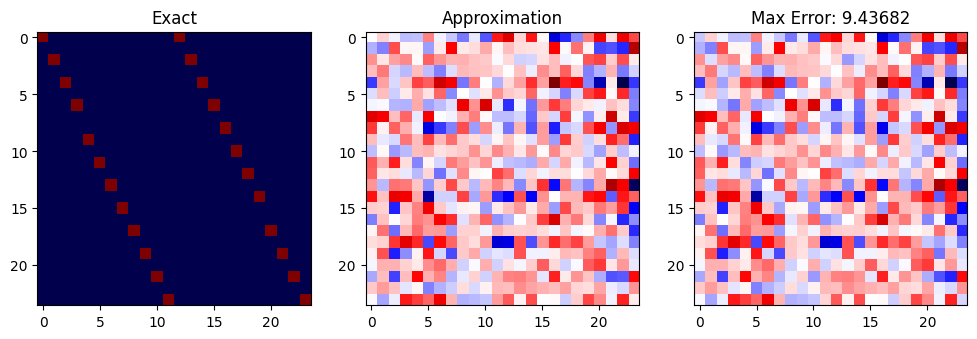

In [ ]:
printer.print_triple_deltas(scheme)

In [ ]:
printer.print(scheme)

Network trained for (3 x 2) @ (2 x 4) using 8 out of 24 multiplications; complexity is n^1.963

Using the L2 norm over the field R



In [ ]:
printer.print(scheme, verbose=1)

Network trained for (3 x 2) @ (2 x 4) using 8 out of 24 multiplications; complexity is n^1.963

Using the L2 norm over the field R

Avg L1 error: 10^0.2267, Avg L2 error: 10^0.3501, max error: 10^0.9748



In [ ]:
printer.print(scheme, verbose=2)

Network trained for (3 x 2) @ (2 x 4) using 8 out of 24 multiplications; complexity is n^1.963

Using the L2 norm over the field R

Avg L1 error: 10^0.2267, Avg L2 error: 10^0.3501, max error: 10^0.9748

Products P_i = (alpha_ind * A_nd) * (beta_idm * B_dm)
P_1 = ( 1.435*A[1,1] + -1.169*A[1,2] +  0.819*A[2,1] + -0.736*A[2,2] + -0.424*A[3,1] +  0.763*A[3,2]) * ( 0.291*B[1,1] +  0.340*B[1,2] +  1.145*B[1,3] +  1.540*B[1,4] +  0.901*B[2,1] + -2.050*B[2,2] +  0.633*B[2,3] + -0.027*B[2,4])
P_2 = (-0.439*A[1,1] + -0.890*A[1,2] + -1.763*A[2,1] + -1.101*A[2,2] +  0.397*A[3,1] + -0.165*A[3,2]) * ( 1.822*B[1,1] +  1.167*B[1,2] +  0.234*B[1,3] +  0.216*B[1,4] +  0.389*B[2,1] +  0.441*B[2,2] + -0.336*B[2,3] + -0.983*B[2,4])
P_3 = (-0.195*A[1,1] +  0.219*A[1,2] + -0.789*A[2,1] +  0.751*A[2,2] +  0.699*A[3,1] +  0.965*A[3,2]) * ( 0.763*B[1,1] +  1.020*B[1,2] +  0.414*B[1,3] + -1.064*B[1,4] + -1.128*B[2,1] +  0.175*B[2,2] + -1.778*B[2,3] +  0.383*B[2,4])
P_4 = ( 1.577*A[1,1] +  1.297*A[1,2] + -1.361*

In [ ]:
printer.test(scheme, verbose=0)

0.3500633966562883

Avg L1 error: 10^0.2267, Avg L2 error: 10^0.3501, max error: 10^0.9748


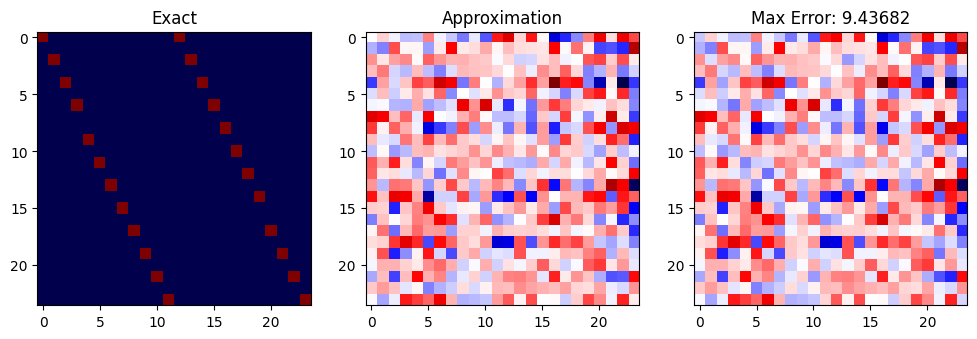

In [ ]:
printer.test(scheme, verbose=4)

In [ ]:
# @title File Save/Read Functions
def download_file(n, d, m, p, number, scheme_or_diagram='scheme'):
  from google.colab import files
  if scheme_or_diagram == 'scheme':
    files.download(f"{n}_{d}_{m}_{p}_e{number:.3f}_alpha_pnd.pkl")
    files.download(f"{n}_{d}_{m}_{p}_e{number:.3f}_beta__pdm.pkl")
    files.download(f"{n}_{d}_{m}_{p}_e{number:.3f}_gamma_nmp.pkl")
  if scheme_or_diagram == 'diagram':
    files.download(f'{n}_{d}_{m}_scheme_{p}_prod_{number:.3f}_best.png')

def delete_file(n, d, m, p, number, scheme_or_diagram):
  import os
  if scheme_or_diagram == 'scheme':
    os.remove(f"{n}_{d}_{m}_{p}_e{number:.3f}_alpha_pnd.pkl")
    os.remove(f"{n}_{d}_{m}_{p}_e{number:.3f}_beta__pdm.pkl")
    os.remove(f"{n}_{d}_{m}_{p}_e{number:.3f}_gamma_nmp.pkl")
  if scheme_or_diagram == 'diagram':
    os.remove(f'{n}_{d}_{m}_scheme_{p}_prod_{number:.3f}_best.png')

# Save the scheme to Colab
score = printer.dump_to_file(scheme)
print(f"Score: {score}")

# Download the file from Colab to your computer. Remember to specify which scheme you want!
# download_file(n=3, d=3, m=3, p=22, number=-15.000, scheme_or_diagram='scheme')

# Read into locals() a scheme from Colab's files. Remember to specify which scheme you want!
factory.read_from_files(scheme, n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=score, verbose=2)

# Delete a scheme from Colab. Remember to specify which scheme you want!
delete_file(n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=score, scheme_or_diagram='scheme')

Score: 0.35
Network trained for (3 x 2) @ (2 x 4) using 8 out of 24 multiplications; complexity is n^1.963

Using the L1 norm over the field None

Avg L1 error: 10^0.2267, Avg L2 error: 10^0.3501, max error: 10^0.9748

Products P_i = (alpha_ind * A_nd) * (beta_idm * B_dm)
P_1 = ( 1.435*A[1,1] + -1.169*A[1,2] +  0.819*A[2,1] + -0.736*A[2,2] + -0.424*A[3,1] +  0.763*A[3,2]) * ( 0.291*B[1,1] +  0.340*B[1,2] +  1.145*B[1,3] +  1.540*B[1,4] +  0.901*B[2,1] + -2.050*B[2,2] +  0.633*B[2,3] + -0.027*B[2,4])
P_2 = (-0.439*A[1,1] + -0.890*A[1,2] + -1.763*A[2,1] + -1.101*A[2,2] +  0.397*A[3,1] + -0.165*A[3,2]) * ( 1.822*B[1,1] +  1.167*B[1,2] +  0.234*B[1,3] +  0.216*B[1,4] +  0.389*B[2,1] +  0.441*B[2,2] + -0.336*B[2,3] + -0.983*B[2,4])
P_3 = (-0.195*A[1,1] +  0.219*A[1,2] + -0.789*A[2,1] +  0.751*A[2,2] +  0.699*A[3,1] +  0.965*A[3,2]) * ( 0.763*B[1,1] +  1.020*B[1,2] +  0.414*B[1,3] + -1.064*B[1,4] + -1.128*B[2,1] +  0.175*B[2,2] + -1.778*B[2,3] +  0.383*B[2,4])
P_4 = ( 1.577*A[1,1] +  1.297*A

### Factory Tests

In [ ]:
for n in range(1,9):
  for d in range(1,9):
    for m in range(1,9):
      factory.set_scheme(scheme, preset='random', n=n, d=d, m=m)
      if n == d == m: print(printer.test(scheme))

0.3808811100793731
0.4327500294910537
0.45009364918010414
0.43012343223256116
0.4756588243983928
0.47155491538761873
0.4764556566264397
0.4365332297494725


In [ ]:
for n in range(1,9):
  for d in range(1,9):
    for m in range(1,9):
      factory.set_scheme(scheme, preset='complex', n=n, d=d, m=m)
      if n == d == m: print(printer.test(scheme))

1.1261003447547135
0.8885122332665276
0.8114748889962866
0.8667198561135793
0.8013897821405795
0.8140327294345339
0.8368509292629664
0.8232210843394835


In [ ]:
for n in range(1,7):
  for d in range(1,7):
    for m in range(1,7):
      factory.set_scheme(scheme, preset='naive', n=n, d=d, m=m)
      if printer.test(scheme) != -math.inf:
        print("failed on test: ",n)

In [ ]:
max_size = 5
for n in range(1,max_size):
  for d in range(1,max_size):
    for m in range(1,max_size):
      for level in range(0,3):
        factory.set_scheme(scheme, fourier=level, n=n, d=d, m=m)
        if printer.test(scheme) > -14:
            print("failed on test: ",n,d,m,level, printer.test(scheme))

In [ ]:
factory.set_scheme(scheme, preset='strassen')
if printer.test(scheme) != -math.inf:
  print("failed on test: strassen")
factory.set_scheme(scheme, preset='winograd')
if printer.test(scheme) > -14:
  print("failed on test: winograd")
factory.set_scheme(scheme, preset='laderman')
if printer.test(scheme) > -14:
  print("failed on test: laderman")

In [ ]:
outer = BrentScheme()
factory.set_scheme(outer, 'strassen', n=2)
inner = BrentScheme()
factory.set_scheme(inner, 'strassen', n=2)

result = factory.compose_schemes(outer, inner)
if result.n != outer.n * inner.n:
  print(f"Matrix Sizes Failed for test 1")
if result.p != outer.p * inner.p:
  print(f"Product Size Failed for test 1")
if printer.test(result) > -13:
  print(f"Accuracy Failed for test 1")


outer = BrentScheme()
factory.set_scheme(outer, 'strassen', n=2)
inner = BrentScheme()
factory.set_scheme(inner, 'laderman', n=2)

result = factory.compose_schemes(outer, inner)
if result.n != outer.n * inner.n:
  print(f"Matrix Sizes Failed for test 2")
if result.p != outer.p * inner.p:
  print(f"Product Size Failed for test 2")
if printer.test(result) > -13:
  print(f"Accuracy Failed for test 2")

### Manipulator Tests

In [ ]:
manipulator.set_norm(scheme, norm=1, field='R')
printer.print(scheme)
print(scheme.norm(torch.Tensor([1,2,3])))
print(scheme.measure(torch.Tensor([1,2,3])))

manipulator.set_norm(scheme, norm=2, field='R')
printer.print(scheme)
print(scheme.norm(torch.Tensor([1,2,3])))
print(scheme.measure(torch.Tensor([1,2,3])))

manipulator.set_norm(scheme, norm=3, field='R')
printer.print(scheme)
print(scheme.norm(torch.Tensor([1,2,3])))
print(scheme.measure(torch.Tensor([1,2,3])))

manipulator.set_norm(scheme, norm=torch.inf, field='R')
printer.print(scheme)
print(scheme.norm(torch.Tensor([1,2,3])))
print(scheme.measure(torch.Tensor([1,2,3])))

manipulator.set_norm(scheme, norm=1, field='C')
printer.print(scheme)
print(scheme.norm(torch.Tensor([1,2,3])))
print(scheme.measure(torch.Tensor([1,2,3])))

manipulator.set_norm(scheme, norm=torch.inf, field='C')
printer.print(scheme)
print(scheme.norm(torch.Tensor([1,2,3])))
print(scheme.measure(torch.Tensor([1,2,3])))

Network trained for (3 x 3) @ (3 x 3) using 23 out of 27 multiplications; complexity is n^2.854

Using the L1 norm over the field R

tensor(6.)
tensor(2.)
Network trained for (3 x 3) @ (3 x 3) using 23 out of 27 multiplications; complexity is n^2.854

Using the L2 norm over the field R

tensor(14.)
tensor(2.1602)
Network trained for (3 x 3) @ (3 x 3) using 23 out of 27 multiplications; complexity is n^2.854

Using the L3 norm over the field R

tensor(36.)
tensor(2.2894)
Network trained for (3 x 3) @ (3 x 3) using 23 out of 27 multiplications; complexity is n^2.854

Using the Linf norm over the field R

tensor(3.)
tensor(3.)
Network trained for (3 x 3) @ (3 x 3) using 23 out of 27 multiplications; complexity is n^2.854

Using the L1 norm over the field C

tensor(6.)
tensor(2.)
Network trained for (3 x 3) @ (3 x 3) using 23 out of 27 multiplications; complexity is n^2.854

Using the Linf norm over the field C

tensor(3.)
tensor(3.)


In [ ]:
def delete_file(n, d, m, p, number, scheme_or_diagram):
  import os
  if scheme_or_diagram == 'scheme':
    os.remove(f"{n}_{d}_{m}_{p}_e{number:.3f}_alpha_pnd.pkl")
    os.remove(f"{n}_{d}_{m}_{p}_e{number:.3f}_beta__pdm.pkl")
    os.remove(f"{n}_{d}_{m}_{p}_e{number:.3f}_gamma_nmp.pkl")
  if scheme_or_diagram == 'diagram':
    os.remove(f'{n}_{d}_{m}_scheme_{p}_prod_{number:.3f}_best.png')

factory.set_scheme(scheme, preset='naive', n=2, d=2, m=2)
printer.dump_to_file(scheme, number=10)
factory.read_from_files(scheme, n=2, d=2, m=2, p=8, number=10, verbose=2)
factory.read_from_files(scheme, filename="2_2_2_8_e10.000", verbose=2)
delete_file(n=2, d=2, m=2, p=8, number=10, scheme_or_diagram='scheme')

Network trained for (2 x 2) @ (2 x 2) using 8 out of 8 multiplications; complexity is n^3.000

Using the L1 norm over the field None

Avg L1 error: 10^-inf, Avg L2 error: 10^-inf, max error: 10^-inf

Products P_i = (alpha_ind * A_nd) * (beta_idm * B_dm)
P_1 = ( 1.000*A[1,1]) * ( 1.000*B[1,1])
P_2 = ( 1.000*A[1,2]) * ( 1.000*B[2,1])
P_3 = ( 1.000*A[1,1]) * ( 1.000*B[1,2])
P_4 = ( 1.000*A[1,2]) * ( 1.000*B[2,2])
P_5 = ( 1.000*A[2,1]) * ( 1.000*B[1,1])
P_6 = ( 1.000*A[2,2]) * ( 1.000*B[2,1])
P_7 = ( 1.000*A[2,1]) * ( 1.000*B[1,2])
P_8 = ( 1.000*A[2,2]) * ( 1.000*B[2,2])

Outputs AB_nm = gamma_nmi * P_i
AB[1,1] =  1.000*P_1 +  1.000*P_2
AB[1,2] =  1.000*P_3 +  1.000*P_4
AB[2,1] =  1.000*P_5 +  1.000*P_6
AB[2,2] =  1.000*P_7 +  1.000*P_8

Network trained for (2 x 2) @ (2 x 2) using 8 out of 8 multiplications; complexity is n^3.000

Using the L1 norm over the field None

Avg L1 error: 10^-inf, Avg L2 error: 10^-inf, max error: 10^-inf

Products P_i = (alpha_ind * A_nd) * (beta_idm * B_dm)
P_

In [ ]:
def random_unitary(n):
  from scipy.linalg import qr
  H = np.random.randn(n, n)
  Q, R = qr(H)
  return torch.from_numpy(Q).type(torch.float64)

for n in range(1,7):
  A = random_unitary(2)
  if torch.sum(torch.abs(A @ A.T - torch.eye(2))) > 10**-14:
    print("Unitary matrix generator failed for n=", n)

for n in range(1,6):
  for d in range(1,6):
    for m in range(1,6):
      factory.set_scheme(scheme, preset='naive', n=n, d=d, m=m)
      manipulator.change_basis(scheme, L=random_unitary(n), M=random_unitary(d), R=random_unitary(m))
      if printer.test(scheme) > -14:
        print("failed on test: ", n,d,m)

In [ ]:
def rand_square(n):
  return torch.from_numpy(np.random.randn(n,n)).type(torch.float64)

for n in range(1,7):
  for d in range(1,7):
    for m in range(1,7):
      factory.set_scheme(scheme, preset='naive', n=n, d=d, m=m)
      manipulator.change_basis(scheme, L=rand_square(n), M=rand_square(d), R=rand_square(m))
      if printer.test(scheme) > -11: # bad conditioning introduces some error
          print("failed on accuracy: test", n,d,m,printer.test(scheme))

In [ ]:
def random_right_invertible(l, s=None, r=None):
  if r is None or r < l:
    r = l
  if s is None:
    s = torch.ones((l,))
  _S_ = torch.from_numpy(np.pad(np.diag(s), ((0, 0), (0,r-l)), 'constant', constant_values=((0, 0), (0,0)))).type(torch.float64)
  return random_unitary(l) @ _S_ @ random_unitary(r)

for n in range(2,4):
  for m in range(n-1, n+3):
    A = random_right_invertible(l=n,r=m)
    A_inv = torch.linalg.pinv(A)
    if torch.sum(torch.abs(A @ A_inv - torch.eye(n))) > 10**-14:
      print("Right Invertable matrix generator failed for n=", n)

for n in range(2,4):
  for d in range(2,4):
    for m in range(2,4):
      for d1 in range(d-1, d+1):
        factory.set_scheme(scheme, preset='naive', n=n, d=d, m=m)
        # d1 <= d
        manipulator.change_basis(scheme, M=random_right_invertible(l=d1,r=d))
        if printer.test(scheme) > -14:
          if d1 < d:
            print("failed on accuracy: test", n,d,d1,m,printer.test(scheme))
          else:
            print("failed on square basis!")
        if scheme.p != n*d*m or scheme.alpha_pnd.size(0) != scheme.p: # number of products stays the same as the larger scheme (inefficient)
          print("failed on size: test", n,d,d1,m,scheme.p)
        if scheme.alpha_pnd.size(2) != d1 or scheme.beta__pdm.size(1) != d1: # number of products stays the same as the larger scheme (inefficient)
          print("failed on axes: test", n,d,d1,m,scheme.p)

In [ ]:
for n in range(3,6):
  for d in range(3,6):
    for m in range(3,6):
      for n1 in range(n-2, n+1):
        for d1 in range(d-2, d+1):
          for m1 in range(m-2, m+1):
            factory.set_scheme(scheme, preset='naive', n=n, d=d, m=m)
            # k1 <= k for all k
            manipulator.change_basis(scheme, L=random_right_invertible(l=n1,r=n).T, M=random_right_invertible(l=d1,r=d), R=random_right_invertible(l=m1,r=m))
            if printer.test(scheme) > -14:
              if n < n1 or m < m1 or d < d1:
                print("failed on accuracy: test", n,n1,d,d1,m,m1,printer.test(scheme))
              else:
                print("failed on square basis!")
            if scheme.p != n*d*m or scheme.gamma_nmp.size(2) != scheme.p: # number of products stays the same as the larger scheme (inefficient)
              print("failed on size: test", n,n1,d,d1,m,m1,scheme.p)
            if scheme.gamma_nmp.size(0) != n1 or scheme.beta__pdm.size(2) != m1: # number of products stays the same as the larger scheme (inefficient)
              print("failed on axes: test", n,d,d1,m,scheme.p)

In [ ]:
# see if the products are in groups of four according to tpye of product (test sorting products)
factory.set_scheme(scheme, 'strassen')
printer.print(scheme, verbose=2)
# then mess them up
permute = np.arange(scheme.p)
np.random.shuffle(permute)
print(permute)
manipulator.permute_products(scheme, permutation=permute)
printer.print(scheme, verbose=2)

Network trained for (2 x 2) @ (2 x 2) using 7 out of 8 multiplications; complexity is n^2.807

Using the L1 norm over the field R

Avg L1 error: 10^-inf, Avg L2 error: 10^-inf, max error: 10^-inf

Products P_i = (alpha_ind * A_nd) * (beta_idm * B_dm)
P_1 = ( 1.000*A[1,1] +  1.000*A[2,2]) * ( 1.000*B[1,1] +  1.000*B[2,2])
P_2 = ( 1.000*A[2,1] +  1.000*A[2,2]) * ( 1.000*B[1,1])
P_3 = ( 1.000*A[1,1]) * ( 1.000*B[1,2] + -1.000*B[2,2])
P_4 = ( 1.000*A[2,2]) * (-1.000*B[1,1] +  1.000*B[2,1])
P_5 = ( 1.000*A[1,1] +  1.000*A[1,2]) * ( 1.000*B[2,2])
P_6 = (-1.000*A[1,1] +  1.000*A[2,1]) * ( 1.000*B[1,1] +  1.000*B[1,2])
P_7 = ( 1.000*A[1,2] + -1.000*A[2,2]) * ( 1.000*B[2,1] +  1.000*B[2,2])

Outputs AB_nm = gamma_nmi * P_i
AB[1,1] =  1.000*P_1 +  1.000*P_4 + -1.000*P_5 +  1.000*P_7
AB[1,2] =  1.000*P_3 +  1.000*P_5
AB[2,1] =  1.000*P_2 +  1.000*P_4
AB[2,2] =  1.000*P_1 + -1.000*P_2 +  1.000*P_3 +  1.000*P_6

[6 2 3 0 5 4 1]
Network trained for (2 x 2) @ (2 x 2) using 7 out of 8 multiplications;

In [ ]:
factory.set_scheme(scheme, 'naive', n=2)
manipulator.add_noise(scheme, epsilon=10**-3)
print("-3: ", printer.test(scheme))
manipulator.round(scheme, sig_figs=2)
if printer.test(scheme) != -np.inf:
  print("rounding didn't work")
manipulator.add_noise(scheme, epsilon=10**-3)
manipulator.chop(scheme, num=1, verbose=2)
manipulator.round(scheme, sig_figs=2)
printer.print(scheme)

-3:  -3.020364182105481
The gamma 2-tensors associated with each product have magnitudes: tensor([1.0018, 1.0012, 1.0025, 1.0023, 1.0038, 1.0014, 1.0024, 1.0039],
       dtype=torch.float64)
Dropping the product with magnitude: 1.0012165469670435
p is now: 7
Network trained for (2 x 2) @ (2 x 2) using 7 out of 8 multiplications; complexity is n^2.807

Using the L1 norm over the field R



In [ ]:
factory.set_scheme(scheme, 'naive', n=2, d=2, m=2)
manipulator.change_basis(scheme, L=random_unitary(2), M=random_unitary(2), R=random_unitary(2))

printer.print(scheme, verbose=2)
manipulator.enforce_zero_num(scheme, num_zeros_enforced=[2,2,2], decay_factor=0.0)
printer.print(scheme, verbose=2)

Network trained for (2 x 2) @ (2 x 2) using 8 out of 8 multiplications; complexity is n^3.000

Using the L1 norm over the field R

Avg L1 error: 10^-16.0838, Avg L2 error: 10^-15.8548, max error: 10^-15.4398

Products P_i = (alpha_ind * A_nd) * (beta_idm * B_dm)
P_1 = ( 0.383*A[1,1] +  0.343*A[1,2] +  0.638*A[2,1] +  0.573*A[2,2]) * ( 0.058*B[1,1] +  0.742*B[1,2] +  0.052*B[2,1] +  0.666*B[2,2])
P_2 = ( 0.343*A[1,1] + -0.383*A[1,2] +  0.573*A[2,1] + -0.638*A[2,2]) * ( 0.052*B[1,1] +  0.666*B[1,2] + -0.058*B[2,1] + -0.742*B[2,2])
P_3 = ( 0.383*A[1,1] +  0.343*A[1,2] +  0.638*A[2,1] +  0.573*A[2,2]) * ( 0.742*B[1,1] + -0.058*B[1,2] +  0.666*B[2,1] + -0.052*B[2,2])
P_4 = ( 0.343*A[1,1] + -0.383*A[1,2] +  0.573*A[2,1] + -0.638*A[2,2]) * ( 0.666*B[1,1] + -0.052*B[1,2] + -0.742*B[2,1] +  0.058*B[2,2])
P_5 = ( 0.638*A[1,1] +  0.573*A[1,2] + -0.383*A[2,1] + -0.343*A[2,2]) * ( 0.058*B[1,1] +  0.742*B[1,2] +  0.052*B[2,1] +  0.666*B[2,2])
P_6 = ( 0.573*A[1,1] + -0.638*A[1,2] + -0.343*A[2,1] +  0

In [ ]:
factory.set_scheme(scheme, 'laderman', n=3)
manipulator.reduce_matrices(scheme, axes=[[1], [0], [2]])
manipulator.clean(scheme)
printer.print(scheme, verbose=2)

Network trained for (2 x 2) @ (2 x 2) using 7 out of 8 multiplications; complexity is n^2.807

Using the L1 norm over the field R

Avg L1 error: 10^-inf, Avg L2 error: 10^-inf, max error: 10^-inf

Products P_i = (alpha_ind * A_nd) * (beta_idm * B_dm)
P_1 = ( 1.000*A[1,1] +  1.000*A[1,2] + -1.000*A[2,1] + -1.000*A[2,2]) * ( 1.000*B[1,2])
P_2 = ( 1.000*A[2,1]) * ( 1.000*B[1,1] + -1.000*B[1,2] + -1.000*B[2,1] +  1.000*B[2,2])
P_3 = (-1.000*A[1,2] +  1.000*A[2,1] +  1.000*A[2,2]) * ( 1.000*B[1,2] +  1.000*B[2,1] + -1.000*B[2,2])
P_4 = ( 1.000*A[1,2] + -1.000*A[2,2]) * ( 1.000*B[1,2] + -1.000*B[2,2])
P_5 = ( 1.000*A[1,2]) * ( 1.000*B[2,1])
P_6 = ( 1.000*A[2,1] +  1.000*A[2,2]) * (-1.000*B[2,1] +  1.000*B[2,2])
P_7 = ( 1.000*A[1,1]) * ( 1.000*B[1,1])

Outputs AB_nm = gamma_nmi * P_i
AB[1,1] =  1.000*P_5 +  1.000*P_7
AB[1,2] =  1.000*P_1 +  1.000*P_3 +  1.000*P_5 +  1.000*P_6
AB[2,1] =  1.000*P_2 +  1.000*P_3 +  1.000*P_4 +  1.000*P_5
AB[2,2] =  1.000*P_3 +  1.000*P_4 +  1.000*P_5 +  1.000*P_

In [ ]:
manipulator.normalize(scheme)
printer.print(scheme, verbose=2)

Network trained for (2 x 2) @ (2 x 2) using 7 out of 8 multiplications; complexity is n^2.807

Using the L1 norm over the field R

Avg L1 error: 10^-16.3732, Avg L2 error: 10^-16.0097, max error: 10^-15.6438

Products P_i = (alpha_ind * A_nd) * (beta_idm * B_dm)
P_1 = ( 1.000*A[1,1] +  1.000*A[1,2] + -1.000*A[2,1]) * (-1.000*B[1,1] +  1.000*B[1,2] +  1.000*B[2,1])
P_2 = (-1.000*A[1,1] +  1.000*A[2,1]) * (-1.000*B[1,1] +  1.000*B[2,1])
P_3 = ( 1.000*A[1,1] +  1.000*A[1,2]) * ( 1.000*B[1,1] + -1.000*B[1,2])
P_4 = (-0.397*A[1,1] + -0.397*A[1,2] +  0.397*A[2,1] +  0.397*A[2,2]) * ( 1.587*B[2,1])
P_5 = ( 1.587*A[1,2]) * ( 0.397*B[1,1] + -0.397*B[1,2] + -0.397*B[2,1] +  0.397*B[2,2])
P_6 = ( 1.587*A[2,1]) * ( 1.587*B[1,2])
P_7 = ( 1.000*A[2,2]) * ( 1.000*B[2,2])

Outputs AB_nm = gamma_nmi * P_i
AB[1,1] =  1.000*P_1 +  1.000*P_2 +  1.000*P_3 +  0.397*P_6
AB[1,2] =  1.000*P_1 +  1.000*P_2 +  1.587*P_5 +  0.397*P_6
AB[2,1] =  1.000*P_1 +  1.000*P_3 +  1.587*P_4 +  0.397*P_6
AB[2,2] =  0.397*P_6

### Scheme Methods Tests

In [ ]:
factory.set_scheme(scheme, 'naive', n=3, d=3, m=3)
for i in range (10):
  A = random_unitary(3)
  B = random_unitary(3)
  if torch.log10(scheme.measure(scheme(A, B) - (A @ B))) > -14:
    print("failure")

### Single-Epoch Training Tests

In [ ]:
factory.set_scheme(scheme, 'random', n=3, p=22)
epochs = 50

for i in range(epochs):
  stepper.epoch_pseudoinverse(scheme)
if printer.test(scheme) > -1.0:
  print("Run pseudoinverse test again, may be faulty: ", printer.test(scheme))

In [ ]:
factory.set_scheme(scheme, 'random', n=2, d=2, m=2, p=8)
epochs = 300

for i in range(epochs):
  stepper.epoch(scheme, momentum=0.9)
if printer.test(scheme) > -1:
  print("Run torch test again, may be faulty: ", printer.test(scheme))

### Multi-Epoch Training Tests

In [ ]:
factory.set_scheme(scheme, 'random', n=2, d=2, m=2, p=8)
trainer.train(scheme, epochs=100, batch_size=1, lr=1e-2, momentum=0.9, verbose=0)
#FIXME: Implement a tempurature related to accuracy

Network trained for (3 x 3) @ (3 x 3) using 22 out of 27 multiplications; complexity is n^2.814

Using the L1 norm over the field R

Avg L1 error: 10^0.5451, Avg L2 error: 10^0.6555, max error: 10^1.2851



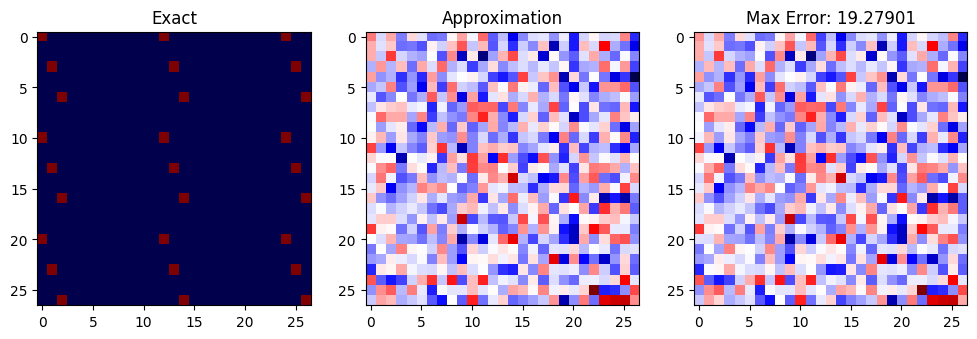

In [ ]:
factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
manipulator.set_norm(scheme, norm=1, field='R')
trainer.train(scheme, epochs=500, batch_size=10, use_L2=False, verbose=1)
printer.print(scheme, verbose=1)
printer.print_triple_deltas(scheme)

Network trained for (3 x 3) @ (3 x 3) using 22 out of 27 multiplications; complexity is n^2.814

Using the L2 norm over the field R

Avg L1 error: 10^0.5009, Avg L2 error: 10^0.6258, max error: 10^1.2846



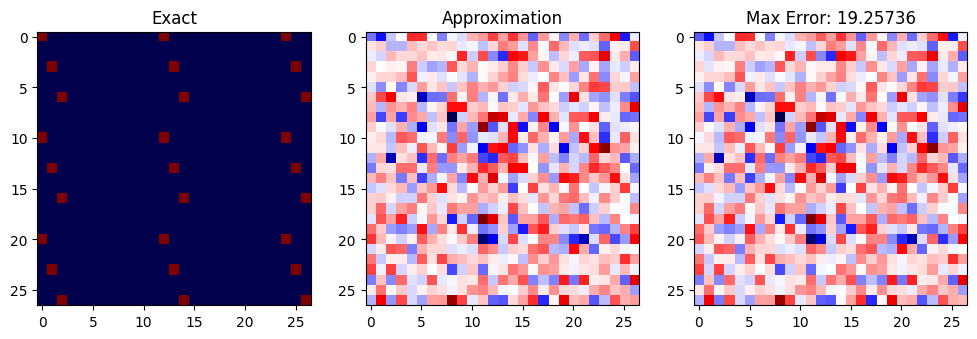

In [ ]:
factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
trainer.train(scheme, epochs=500, batch_size=10, use_L2=False, verbose=1)
printer.print(scheme, verbose=1)
printer.print_triple_deltas(scheme)

Network trained for (3 x 3) @ (3 x 3) using 22 out of 27 multiplications; complexity is n^2.814

Using the L1000 norm over the field R

Avg L1 error: 10^0.5549, Avg L2 error: 10^0.6654, max error: 10^1.2736



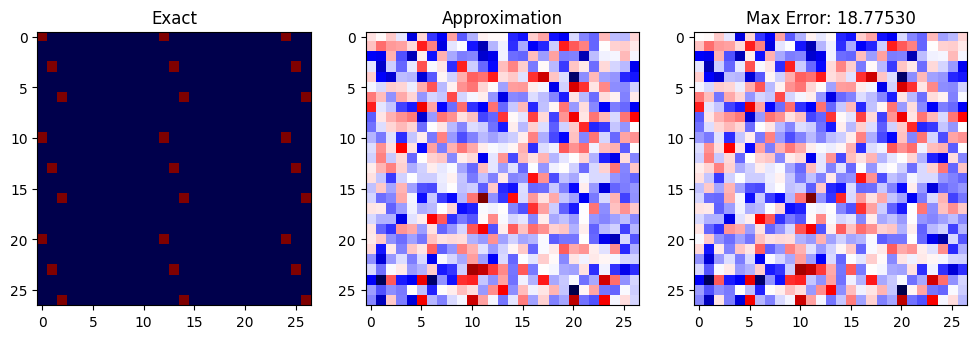

In [ ]:
factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
manipulator.set_norm(scheme, norm=1000, field='R')
trainer.train(scheme, epochs=500, batch_size=10, use_L2=False, verbose=1)
printer.print(scheme, verbose=1)
printer.print_triple_deltas(scheme)

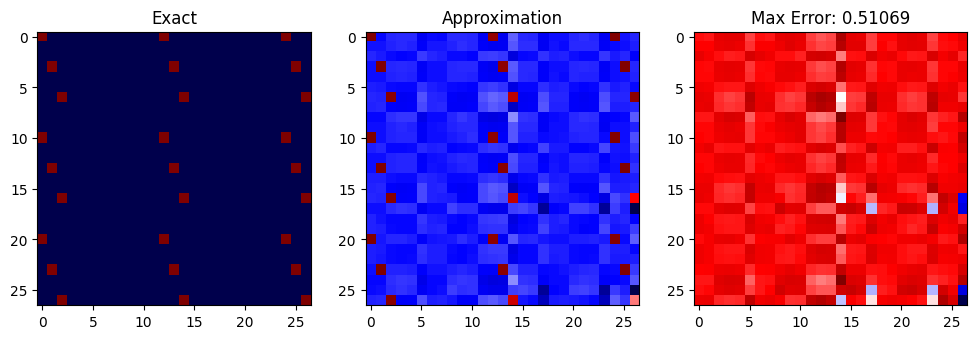

In [ ]:
factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
trainer.train(scheme, epochs=500, batch_size=1, use_L2=True, verbose=1)
printer.print_triple_deltas(scheme)

Network trained for (3 x 3) @ (3 x 3) using 22 out of 27 multiplications; complexity is n^2.814

Using the Linf norm over the field R

Avg L1 error: 10^-1.4717, Avg L2 error: 10^-1.2800, max error: 10^-0.2918



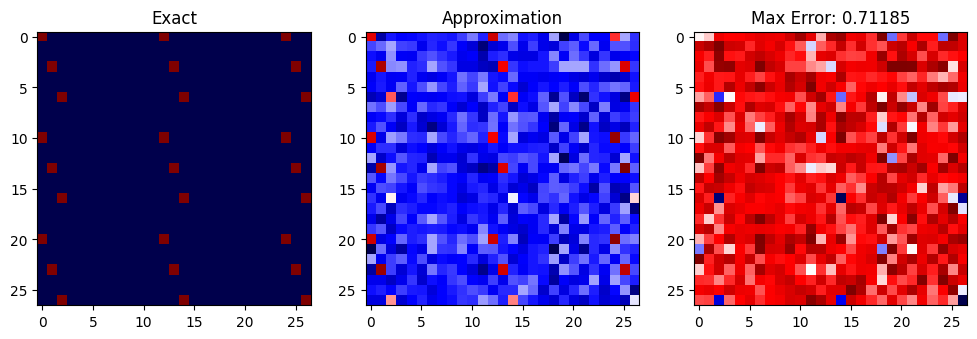

In [ ]:
manipulator.set_norm(scheme, norm=torch.inf, field='R')
printer.print(scheme, verbose=1)
trainer.train(scheme, epochs=200, batch_size=10, lr=1e-5, penalty=1e-7, use_L2=False, verbose=1)
printer.print_triple_deltas(scheme)

Network trained for (3 x 3) @ (3 x 3) using 27 out of 27 multiplications; complexity is n^3.000

Using the Linf norm over the field R

Avg L1 error: 10^0.5882, Avg L2 error: 10^0.6928, max error: 10^1.2255



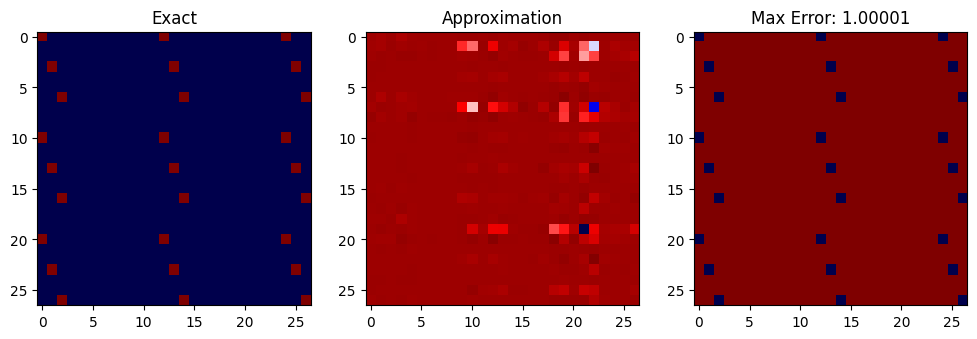

In [ ]:
factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=27)
manipulator.set_norm(scheme, norm=torch.inf, field='R')
printer.print(scheme, verbose=1)
trainer.train(scheme, epochs=200, batch_size=10, lr=1e-2, penalty=1e-5, use_L2=False, verbose=1)
printer.print_triple_deltas(scheme)

In [ ]:
factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
trainer.train(scheme, epochs=500, batch_size=1, lr=1e-2, use_L2=False, penalty=1e-5, verbose=1)

## Workspace

### Catalogue Catchments

In [ ]:
#@title Plot data
def plot_one(df, title, xlabel, ylabel, xvar, yvar, color='blue', label=None, alpha=0.2, **kwargs):
  _df = df.copy()

  # Filter the DataFrame based on the provided keyword arguments
  for key, value in kwargs.items():
    _df = _df[_df[key] == value]

  # Plot the filtered data
  plt.figure(figsize=(10, 6))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if label is None:
    plt.scatter(_df[xvar], _df[yvar], color=color, alpha=alpha)
  else:
    plt.scatter(_df[xvar], _df[yvar], color=color, alpha=alpha, label=label)

In [ ]:
#@title Test Schemes of a given Size n,p for some iterable of seeds
# add default seed selector None that just finds a new seed from the data for that n
def test_schemes(n, p, seeds, epochs, filename, num_rotations=0, step_size=0):
  try:
    # Try to load existing data
    df = pd.read_csv(filename)
  except FileNotFoundError:
    # Create a new DataFrame if file doesn't exist
    df = pd.DataFrame()

  for seed in seeds:
    torch.random.manual_seed(seed)
    np.random.seed(seed)

    new_sample = pd.DataFrame(columns = ['seed', 'n', 'p', 'epochs', 'L1 err', 'L2 err', 'Linf err', 'time'])

    start_time = time.time()
    scheme = BrentScheme()
    factory.set_scheme(scheme, 'random', n=n, d=n, m=n, p=p)
    if step_size > 0:
      for i in range(epochs//step_size):
        stepper.epoch_pseudoinverse(scheme, batch_size=step_size)
        data = printer.test(scheme, verbose=1)
        end_time = time.time()
        new_sample.loc[len(new_sample.index)] = [seed, n, p, (i+1)*step_size, data[0], data[1], data[2], end_time - start_time]
    else:
      stepper.epoch_pseudoinverse(scheme, batch_size=epochs)
      data = printer.test(scheme, verbose=1)
      end_time = time.time()
      new_sample.loc[len(new_sample.index)] = [seed, n, p, epochs, data[0], data[1], data[2], end_time - start_time]

    for i in range(num_rotations):
      manipulator.change_basis(scheme, L=random_unitary(n), M=random_unitary(n), R=random_unitary(n))
      data = printer.test(scheme, verbose=1)
      new_sample.loc[len(new_sample.index)] = [seed, n, p, epochs, data[0], data[1], data[2], end_time - start_time]

    # Append sample to DataFrame
    df = pd.concat((df, new_sample), ignore_index=True)

    # Save updated DataFrame to Google Drive
    df.to_csv(filename, index=False)

In [ ]:
#@title Test Composite Schemes
def test_composed_schemes(n1, n2, p1, p2, epochs, filename, seeds1=None, seeds2=None, num_rotations=0, step_size=0):
  try:
    # Try to load existing data
    df = pd.read_csv(filename)
  except FileNotFoundError:
    # Create a new DataFrame if file doesn't exist
    df = pd.DataFrame(columns = ['seed1', 'seed2', 'L1 err', 'L2 err', 'Linf err',
                                 'n1', 'p1', 'L1 err1', 'L2 err1', 'Linf err1',
                                 'n2', 'p2', 'L1 err2', 'L2 err2', 'Linf err2',
                                 'epochs', 'time'])

  if seeds1 is None:
    # find a seed not in df
    df1 = df[(df['n1'] == n1) & (df['p1'] == p1)]
    seeds1 = [0 if df1['seed1'].empty else df1['seed1'].max() + 1]
  if seeds2 is None:
    # find a seed not in df
    df2 = df[(df['n2'] == n2) & (df['p2'] == p2)]
    seeds2 = [0 if df2['seed2'].empty else df2['seed2'].max() + 1]

  for seed1 in seeds1:
    for seed2 in seeds2:
      new_sample = pd.DataFrame(columns = ['seed1', 'seed2', 'L1 err', 'L2 err', 'Linf err',
                                           'n1', 'p1', 'L1 err1', 'L2 err1', 'Linf err1',
                                           'n2', 'p2', 'L1 err2', 'L2 err2', 'Linf err2',
                                           'epochs', 'time'])

      start_time = time.time()

      torch.random.manual_seed(seed1)
      np.random.seed(seed1)
      inner = BrentScheme()
      factory.set_scheme(inner, 'random', n=n1, d=n1, m=n1, p=p1)
      stepper.epoch_pseudoinverse(inner, batch_size=epochs)
      data1 = printer.test(inner, verbose=1)

      torch.random.manual_seed(seed2)
      np.random.seed(seed2)
      outer = BrentScheme()
      factory.set_scheme(outer, 'random', n=n2, d=n2, m=n2, p=p2)
      stepper.epoch_pseudoinverse(outer, batch_size=epochs)
      data2 = printer.test(outer, verbose=1)

      scheme = factory.compose_schemes(outer, inner)
      data3 = printer.test(scheme, verbose=1)
      end_time = time.time()
      new_sample.loc[len(new_sample.index)] = [seed1, seed2, data3[0], data3[1], data3[2],
                                               n1, p1, data1[0], data1[1], data1[2],
                                               n2, p2, data2[0], data2[1], data2[2],
                                               epochs, end_time - start_time]

      for i in range(num_rotations):
        manipulator.change_basis(scheme, L=random_unitary(n1*n2), M=random_unitary(n1*n2), R=random_unitary(n1*n2))
        data3 = printer.test(scheme, verbose=1)
        end_time_full = time.time()
        new_sample.loc[len(new_sample.index)] = [seed1, seed2, data3[0], data3[1], data3[2],
                                               n1, p1, data1[0], data1[1], data1[2],
                                               n2, p2, data2[0], data2[1], data2[2],
                                               epochs, end_time - start_time]
      # Append sample to DataFrame
      df = pd.concat((df, new_sample), ignore_index=True)

      # Save updated DataFrame to Google Drive
      df.to_csv(filename, index=False)

In [ ]:
#@title Set Up File Location
if False:
  from google.colab import drive
  drive.mount('/content/drive')
  data_location = '/content/drive/MyDrive'
else:
  data_location = '/content'

# filename = data_location + '/matmul_schemes.csv'
filename = data_location + '/matmul_schemes_prods2.csv'
# filename = data_location + '/matmul_schemes_log.csv'

In [ ]:
for n1 in range(2,4):
  for n2 in range(n1,5):
    p1 = n1**2
    p2 = n2**2
    print(f'testing n1={n1}, p1={p1}; n2={n2}, p2={p2}')
    test_composed_schemes(n1, n2, p1, p2, epochs=0, filename=filename, seeds1=trange(20), seeds2=range(20))

testing n1=2, p1=4; n2=2, p2=4


  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-47-70799444c1a7>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, new_sample), ignore_index=True)
100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


testing n1=2, p1=4; n2=3, p2=9


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


testing n1=2, p1=4; n2=4, p2=16


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


testing n1=3, p1=9; n2=3, p2=9


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


testing n1=3, p1=9; n2=4, p2=16


100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


In [ ]:
def num_epochs(n):
  # sometimes the catchments leak into eachother after many epochs.
  # Example: for the first 100 seeds, n=5 has only one catchement until 120 epochs, where seed=0 drops a catchement
  # For n=2 and 3, 250 epochs gets many lines stable (for now)
  # it seems that for larger n, it takes longer for other catchments to appear. The curse of dimentionality. Momentum?
  return [-1,-1,150,150,100,10,5,4,4,3,3,3,3,3,3][n] if n < 14 else 0

# n=2
# for p in trange(n**2,n**2+n): # test p's

for n in range(5,5): # test n's : 9 mins to do 40 seeds
  p = int(n**2 * np.log2(n))
  print(f'testing n={n}, p={p}')
# TRY n=6 UNTIL A NEW CATCHMENT APPEARS
# also try composing schemes of various accuracies and see where they land in the product scheme (multiple product catchements?)
  test_schemes(n=n, p=p, seeds=trange(100), epochs=200, filename=filename, num_rotations=0, step_size=0)

Number of rows: 2000


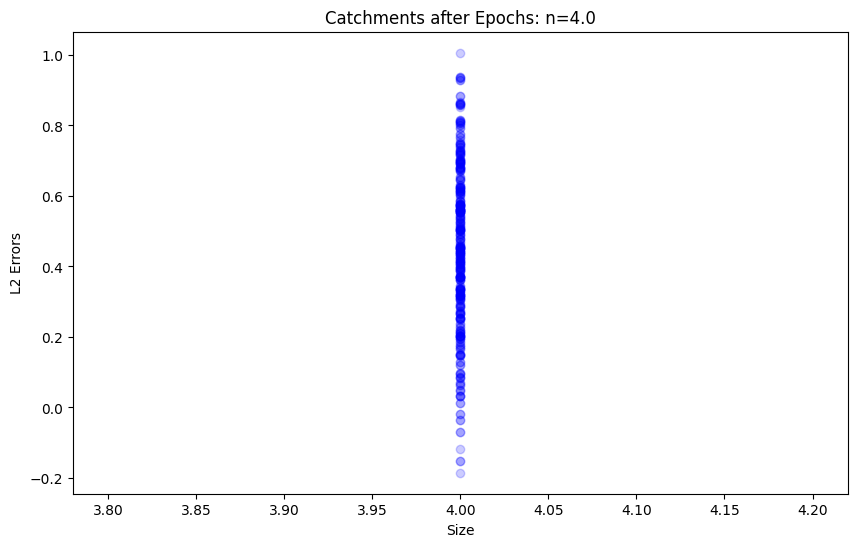

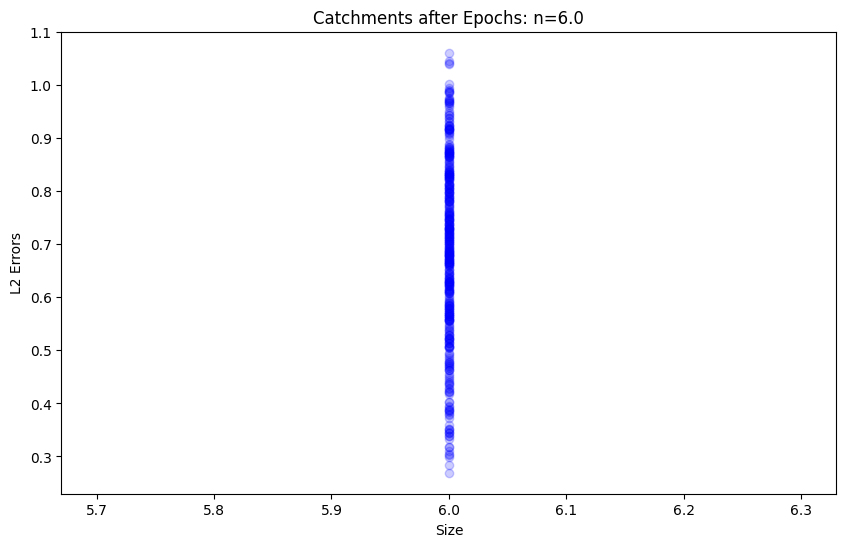

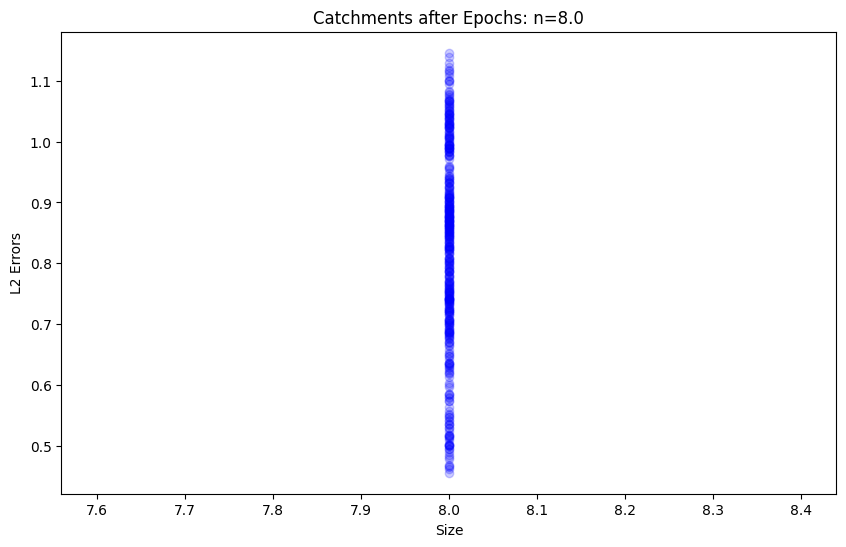

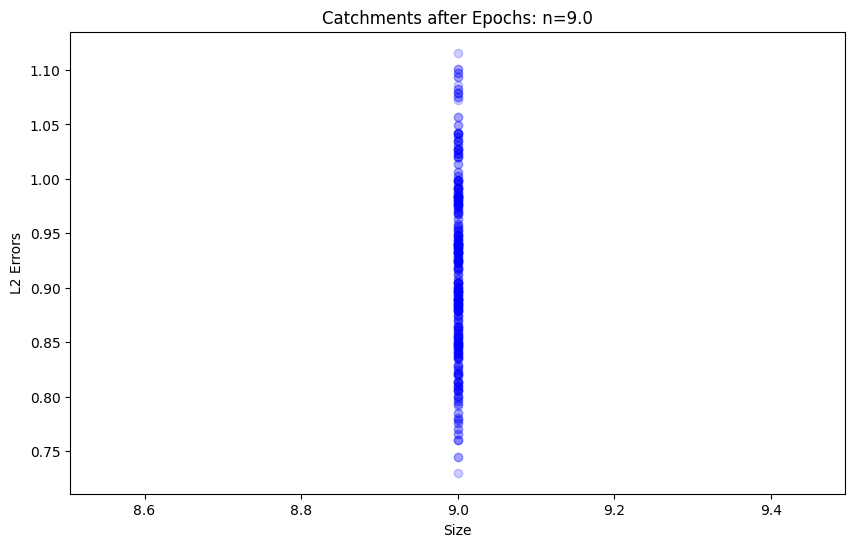

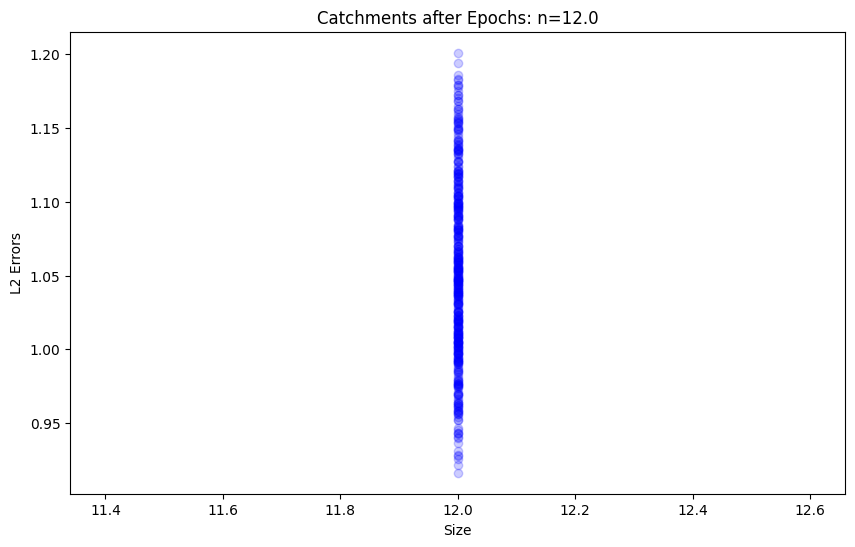

In [ ]:
#@title Read data from file
df = pd.read_csv(filename)
df['n'] = df.n1 * df.n2
df['p'] = df.p1 * df.p2
alpha = 0.2
print(f"Number of rows: {len(df)}")

# Save updated DataFrame to Google Drive
# df.to_csv(filename, index=False)

# n=6
# for p in range(n**2,n**2+n):
for n in df.n.unique(): # test n's
  plot_one(df, f"Catchments after Epochs: n={n}", "Size", "L2 Errors", 'n', 'L2 err', alpha=alpha, n=n)
  plt.show()

# plot_one(df, "Catchments after Epochs", "Epochs", "L1 Errors", 'epochs', 'L1 err', alpha=alpha, n=2, p=4)
# plot_one(df, "Catchments after Epochs", "Epochs", "Linf Errors", 'epochs', 'Linf err', alpha=alpha, n=2, p=4)

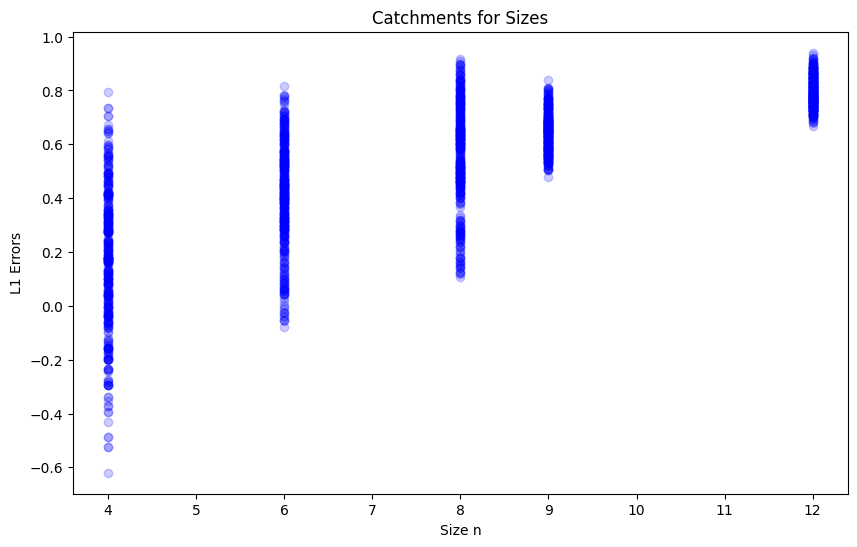

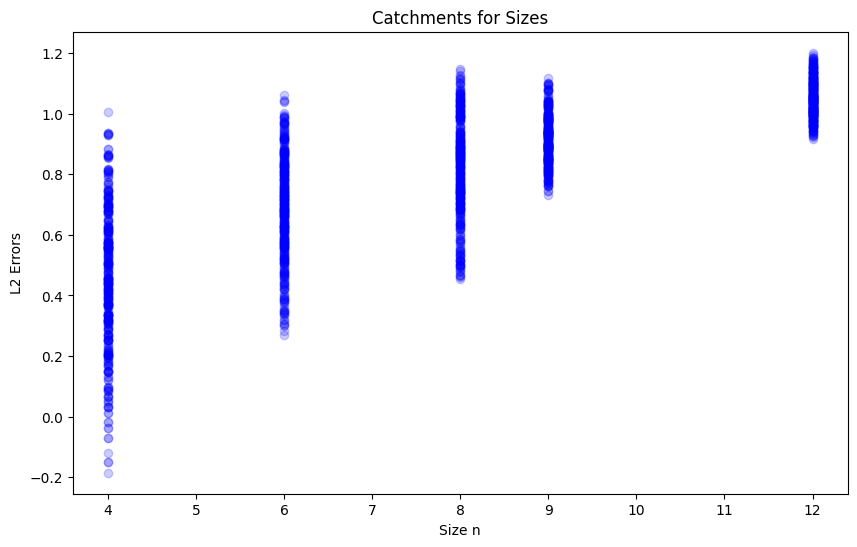

In [ ]:
#@title Display Errors By Size
plot_one(df, "Catchments for Sizes", "Size n", "L1 Errors", 'n', 'L1 err', alpha=alpha)
plot_one(df, "Catchments for Sizes", "Size n", "L2 Errors", 'n', 'L2 err', alpha=alpha)
plt.show()

In [ ]:
#@title prompt: in a dataframe df, for each unique value in column p, find the entry with minimum value in the column L2 err and display the results

# Group the DataFrame by 'p' and find the index of the minimum 'L2 err' for each group
min_indices = df.groupby('p')['L2 err'].idxmin()

# Display the rows with the minimum 'L2 err' for each unique 'p'
df_best = df.loc[min_indices].sort_values(by='L2 err')
df_best

,seed1,seed2,L1 err,L2 err,Linf err,n1,p1,L1 err1,L2 err1,Linf err1,n2,p2,L1 err2,L2 err2,Linf err2,epochs,time,n,p
357,17.0,17.0,-0.619915,-0.185028,1.049356,2.0,4.0,-0.275404,-0.076417,0.524678,2.0,4.0,-0.275404,-0.076417,0.524678,0.0,0.007643,4.0,16.0
747,17.0,7.0,-0.079643,0.269337,1.539272,2.0,4.0,-0.275404,-0.076417,0.524678,3.0,9.0,0.241474,0.366150,1.014594,0.0,0.008327,6.0,36.0
1152,17.0,12.0,0.120056,0.455414,1.685003,2.0,4.0,-0.275404,-0.076417,0.524678,4.0,16.0,0.440858,0.551784,1.160325,0.0,0.015148,8.0,64.0
1347,7.0,7.0,0.480203,0.730187,2.029189,3.0,9.0,0.241474,0.366150,1.014594,3.0,9.0,0.241474,0.366150,1.014594,0.0,0.031626,9.0,81.0
1752,7.0,12.0,0.680935,0.916467,2.174919,3.0,9.0,0.241474,0.366150,1.014594,4.0,16.0,0.440858,0.551784,1.160325,0.0,0.167723,12.0,144.0


In [ ]:
useful_data = df[['n', 'p',
                  'n1', 'p1',
                  'n2', 'p2']]
# useful_data = useful_data[useful_data['n'] == 12]
useful_data['abs L2 err'] = 10**df['L2 err'] / df.n #* df['n']**6
useful_data['abs L2 err1'] = 10**df['L2 err1'] #* df['n1']**6
useful_data['abs L2 err2'] = 10**df['L2 err2'] #* df['n2']**6
useful_data

<ipython-input-54-dec7413492e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_data['abs L2 err'] = 10**df['L2 err'] / df.n #* df['n']**6
<ipython-input-54-dec7413492e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_data['abs L2 err1'] = 10**df['L2 err1'] #* df['n1']**6
<ipython-input-54-dec7413492e3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,n,p,n1,p1,n2,p2,abs L2 err,abs L2 err1,abs L2 err2
0,4.0,16.0,2.0,4.0,2.0,4.0,0.484842,1.451231,1.451231
1,4.0,16.0,2.0,4.0,2.0,4.0,0.943207,1.451231,2.653932
2,4.0,16.0,2.0,4.0,2.0,4.0,0.367458,1.451231,1.061866
3,4.0,16.0,2.0,4.0,2.0,4.0,0.539187,1.451231,1.480876
4,4.0,16.0,2.0,4.0,2.0,4.0,0.929504,1.451231,2.664522
...,...,...,...,...,...,...,...,...,...
1995,12.0,144.0,3.0,9.0,4.0,16.0,0.853545,2.601995,3.956585
1996,12.0,144.0,3.0,9.0,4.0,16.0,0.789926,2.601995,3.660134
1997,12.0,144.0,3.0,9.0,4.0,16.0,0.851777,2.601995,3.948629
1998,12.0,144.0,3.0,9.0,4.0,16.0,0.933550,2.601995,4.325155


In [ ]:
equal_to = df[useful_data['n'] == 12]
equal_to = equal_to.drop(columns=['n','n1','n2','p','p1','p2'])
equal_to

,seed1,seed2,L1 err,L2 err,Linf err,L1 err1,L2 err1,Linf err1,L1 err2,L2 err2,Linf err2,epochs,time
1600,0.0,0.0,0.751623,0.990036,2.460751,0.263655,0.382098,1.016064,0.488878,0.610368,1.444687,0.0,0.181432
1601,0.0,1.0,0.760625,0.999840,2.469912,0.263655,0.382098,1.016064,0.498305,0.620276,1.453848,0.0,0.164370
1602,0.0,2.0,0.745974,0.984808,2.291449,0.263655,0.382098,1.016064,0.483468,0.605077,1.275385,0.0,0.173505
1603,0.0,3.0,0.732546,0.971102,2.383931,0.263655,0.382098,1.016064,0.470051,0.591697,1.367866,0.0,0.127607
1604,0.0,4.0,0.763290,1.005209,2.394070,0.263655,0.382098,1.016064,0.501037,0.625687,1.378006,0.0,0.143665
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,19.0,15.0,0.740077,1.010408,2.418645,0.267708,0.415306,1.110005,0.473414,0.597321,1.341330,0.0,0.154362
1996,19.0,16.0,0.712854,0.976768,2.403982,0.267708,0.415306,1.110005,0.446082,0.563497,1.326667,0.0,0.139453
1997,19.0,17.0,0.745111,1.009507,2.369783,0.267708,0.415306,1.110005,0.478448,0.596446,1.314070,0.0,0.155140
1998,19.0,18.0,0.778664,1.049319,2.561635,0.267708,0.415306,1.110005,0.512008,0.636002,1.484320,0.0,0.142117


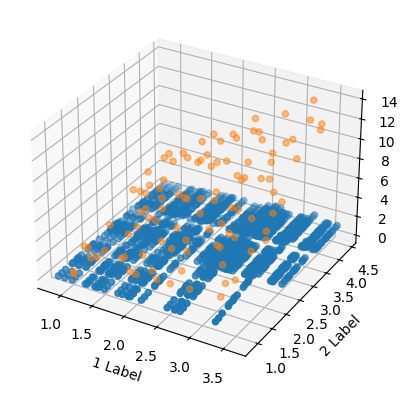

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = useful_data['abs L2 err1']
ys = useful_data['abs L2 err2']
zs = useful_data['abs L2 err']
ax.scatter(xs, ys, zs, marker='o')

Xs = np.linspace(min(xs), max(xs), 100)
Ys = np.linspace(min(ys), max(ys), 100)
np.random.shuffle(Xs)
np.random.shuffle(Ys)
Zs = Xs * Ys

ax.scatter(Xs, Ys, Zs, alpha=0.5)

ax.set_xlabel('1 Label')
ax.set_ylabel('2 Label')
ax.set_zlabel('3 Label')

plt.show()

In [ ]:
# prompt: Using dataframe equal_to: PCA

from sklearn.decomposition import PCA
import pandas as pd

# Select the relevant columns for PCA
X = equal_to[['L2 err', 'L2 err1', 'L2 err2']]

# Create a PCA object
pca = PCA(n_components=3)

# Fit the PCA model to the data
principalComponents = pca.fit_transform(X)

# Create a new DataFrame with the principal components
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'princ 3'])

# Print the explained variance ratio
print(pca.explained_variance_ratio_)
print((pca.components_[0,0]/pca.components_[:,0]))


[8.70772712e-01 1.29184219e-01 4.30691316e-05]
[ 1.          2.28121091 -1.29803902]


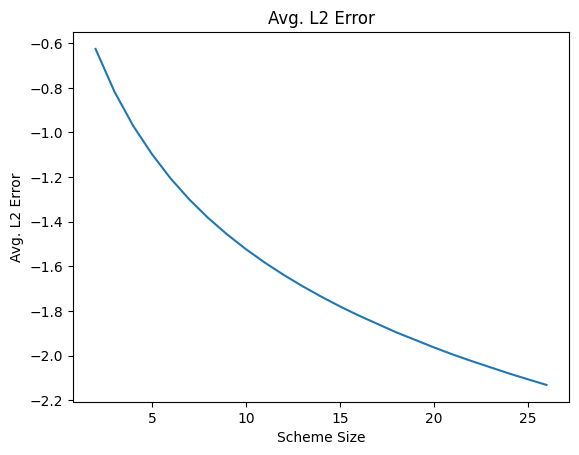

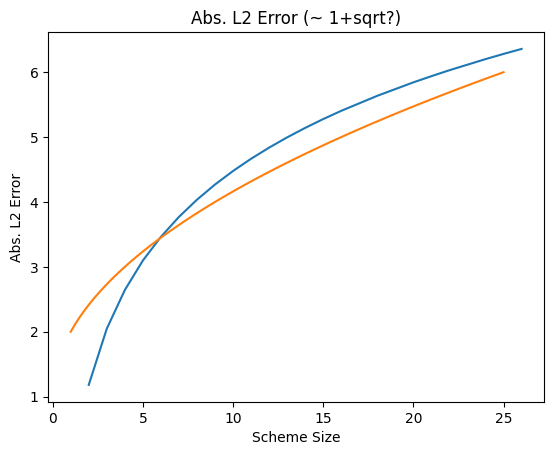

In [ ]:
#@title Average L2 errors decrease

perfect_schema_scores_L2 = {\
  2:  -0.6256,
  3:  -0.8161,
  4:  -0.9700,
  5:  -1.0969,
  6:  -1.2067,
  7:  -1.3011,
  8:  -1.3836,
  9:  -1.4568, # 5s
  10: -1.5227, # 7s
  11: -1.5827, # 21s
  12: -1.6375, # 38s
  13: -1.6881, # 1m 14s
  14: -1.7351, # 1m 46s
  15: -1.7790, # 3m 5s
  16: -1.8200, # 4m 12s
  # 17: -1, # PRIME
  18: -1.8954, # 3 x 6
  # 19: -1, # PRIME
  20: -1.9627, # 4 x 5
  21: -1.9945, # 3 x 7
  22: -2.0239, # 1 x 11
  # 23: -1, # PRIME
  24: -2.0797, # 4 x 6
  25: -2.1058, # 5 x 5
  26: -2.1312, # 2 x 13
  # 27: not enough RAM
  }

plt.plot(perfect_schema_scores_L2.keys(), perfect_schema_scores_L2.values())
plt.title("Avg. L2 Error")
plt.xlabel("Scheme Size")
plt.ylabel("Avg. L2 Error")
plt.show()

for key in perfect_schema_scores_L2:
  perfect_schema_scores_L2[key] += 6 * np.log10(key) # absolute error, not average error (multiply by n**6 entries in triple delta)

plt.plot(perfect_schema_scores_L2.keys(), perfect_schema_scores_L2.values())
plt.title("Abs. L2 Error (~ 1+sqrt?)")
plt.plot(np.linspace(1,25,100), 1+np.sqrt(np.linspace(1,25,100)))
plt.xlabel("Scheme Size")
plt.ylabel("Abs. L2 Error")
plt.show()

### Change Basis of Approximate Scheme to Improve Gradient

In [ ]:
#@title use the SVD of a single product to determine the new basis
factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
factory.read_from_files(scheme, n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=-3.003, verbose=2)

# L, sigmas, R = torch.linalg.svd(scheme.gamma_nmp[:,:,1])
# manipulator.change_basis(scheme, L=L, R=R)
# printer.print(scheme, verbose=3)

# L, sigmas, M = torch.linalg.svd(scheme.alpha_pnd[0,:,:])
# manipulator.change_basis(scheme, L=L, M=M)
# printer.print(scheme, verbose=3)

FileNotFoundError: [Errno 2] No such file or directory: '3_3_3_22_e-3.003_alpha_pnd.pkl'

In [ ]:
#@title Higher order SVD
def HOSVD(orig):
  Sigma = orig.clone()
  U = []

  for i,size in enumerate(Sigma.size()):
    U.append(None)
    temp = Sigma.transpose(0,i).reshape(size, -1)
    U[i], _, _ = torch.linalg.svd(temp)
    Sigma = (U[i].T @ temp).reshape(Sigma.transpose(0,i).size()).transpose(0,i)

  return Sigma, U

In [ ]:
M = rand_square(3)
Sigma,U = HOSVD(M)
assert torch.allclose(torch.einsum("PN,pP,nN->pn", Sigma, U[0], U[1]), M, rtol=1e-10)
# display(Sigma.round(decimals=4))

T = torch.rand((3,4,5))
Sigma,U = HOSVD(T)
assert torch.allclose(torch.einsum("PND,pP,nN,dD->pnd", Sigma, U[0], U[1], U[2]), T, atol=1e-11, rtol=1e-3)

factory.set_scheme(scheme, 'strassen')
Sigma,U = HOSVD(scheme.alpha_pnd)
assert torch.allclose(torch.einsum("PND,pP,nN,dD->pnd", Sigma, U[0], U[1], U[2]), scheme.alpha_pnd, rtol=1e-10)
# display(torch.einsum("Pnd,pP->pnd", Sigma, U[0]).round(decimals=4))
# display(U[1], U[2])

factory.set_scheme(scheme, 'strassen')
manipulator.change_basis(scheme, L=random_unitary(scheme.n), M=random_unitary(scheme.d), R=random_unitary(scheme.m))
Sigma,U = HOSVD(scheme.TRIPLE_DELTA_nmnddm)
assert torch.allclose(torch.einsum("cCaAbB,cx,CX,ay,AY,bz,BZ->xXyYzZ", Sigma, U[0], U[1], U[2], U[3], U[4], U[5]), scheme.TRIPLE_DELTA_nmnddm, rtol=1e-10)
assert torch.allclose(Sigma, scheme.TRIPLE_DELTA_nmnddm, rtol=1e-10)
Sigma,U = HOSVD(scheme.forward())

In [ ]:
# factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=16)
stepper.epoch_pseudoinverse(scheme, batch_size=1000)
printer.print(scheme, verbose=1)
printer.print_triple_deltas(scheme)

Sigma,U = HOSVD(scheme.forward())

# display(U[0])
# display(U[1])
# display(U[2])
# display(U[3]) # close
# display(U[4]) # close
# display(U[5]) # close

# print()

# display(U[0] @ U[2]) # n (gamma @ alpha)
# display(U[1] @ U[5]) # d (gamma @ beta)
# display(U[3] @ U[4]) # m (alpha @ beta)
# each matrix is an involution?

print()

# printer.print_triple_deltas(scheme, output=Sigma.reshape((scheme.n*scheme.m, scheme.n*scheme.d**2*scheme.m)))

manipulator.change_basis(scheme, L=U[2].T, M=U[3].T, R=U[5].T)
# manipulator.round(scheme, 4)
printer.print(scheme, verbose=1)
printer.print_triple_deltas(scheme)

In [ ]:
stepper.epoch_pseudoinverse(scheme, batch_size=10000)
printer.print(scheme, verbose=1)

In [ ]:
manipulator.set_norm(scheme, 5)
manipulator.normalize(scheme)
printer.print(scheme, verbose=3)
torch.einsum("pnd,pDM->pndDM", scheme.alpha_pnd, scheme.beta__pdm).reshape(scheme.p, -1).svd()[1]

### Change of Basis along Product Axis

In [ ]:
# use the dot product case to see how we can deduce the basis of a random scheme
# TRY THE SAME WITH AN OUTER PRODUCT: p <= n*m, with d=1
# simplifies the terms somewhat, but they were mixed. A naive scheme with standard basis change is a repeated array, but a random scheme seems to have extra degrees of freedom.
# gets the first term to (1 x 1), every nth term to (1 x dm), and the first m terms to (nd x 1)

seed = 1
torch.random.manual_seed(seed)
np.random.seed(seed)

# get a random outer product scheme
factory.set_scheme(scheme, 'random', n=1, d=4, m=1, p=4) # inner product. Trivial. alpha or beta entirely determined by exactly the other two, exactly by an inverse.
factory.set_scheme(scheme, 'random', n=2, d=1, m=2, p=4) # outer product. Indicates that there is another kind of change of basis that affects some products.
factory.set_scheme(scheme, 'random', n=3, d=1, m=3, p=9) # outer product. Indicates that there is another kind of change of basis that affects some products.
# factory.set_scheme(scheme, 'random', n=3, d=1, m=2, p=6) # outer product. Indicates that there is another kind of change of basis that affects some products.
# factory.set_scheme(scheme, 'random', n=2, d=2, m=1, p=4) # mat-vec product. NOT READY
manipulator.set_norm(scheme, np.inf)
for i in range(150):
  stepper.epoch_pseudoinverse(scheme, batch_size=20)
  manipulator.normalize(scheme)

# factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
# factory.read_from_files(scheme, n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=-3.110, verbose=1) # the goal


# factory.set_scheme(scheme, 'naive', n=2, d=2, m=1, p=4) # mat-vec product
# printer.print(scheme, verbose=2)
# manipulator.change_basis(scheme, L=rand_square(2), M=rand_square(2))

# default basis
new_L = torch.eye(scheme.n)
new_R = torch.eye(scheme.m)
new_M = torch.eye(scheme.d)

# fix it by using its own natural basis
if scheme.n == 1 and scheme.m == 1: # inner product
  new_M = scheme.beta__pdm[:scheme.d,:,0] # can equivalently use a pseudoinverse over selected entries of alpha
elif scheme.d == 1: # outer product
  # scheme.gamma_nmp = torch.linalg.pinv(torch.einsum("pnd,pdm->pnm", scheme.alpha_pnd, scheme.beta__pdm).reshape(scheme.p, -1)).reshape(scheme.n, scheme.m, scheme.p)
  new_L = torch.linalg.pinv(scheme.alpha_pnd[:scheme.n,:,0]) # instead of this pinv, what is the slice that gives us a basis without pinv? Use gamma?
  new_R = torch.linalg.pinv(scheme.beta__pdm[:scheme.m,0,:]).T
elif scheme.m == 1: # mat-vec product
  new_L = torch.linalg.pinv(scheme.alpha_pnd[:scheme.n**2:scheme.n,:,0]) # just this, some entries of alpha to zero
  new_M = scheme.beta__pdm[:scheme.d,:,0] # just this, some entries of beta to zero
else: # not yet implemented
  print("NOT YET IMPLEMENTED **************************************************************************************************************")

printer.print(scheme, verbose=2)
manipulator.change_basis(scheme, L=new_L, M=new_M, R=new_R)
if scheme.n == 1 and scheme.m == 1:
  manipulator.normalize(scheme)
# manipulator.normalize(scheme)
manipulator.round(scheme, 13)
printer.print(scheme, verbose=2)

In [ ]:
display(torch.einsum("pnd,pdm->pnm", scheme.alpha_pnd, scheme.beta__pdm).reshape(scheme.p, -1).round(decimals=3))

There will always be more p than n or m i.e. as $nm \le p \le ndm$, $p \ge \max(n,m)$

Furthermore, if $p \ge \max(nd,md)$, and we flatten alpha and beta into $\alpha_{pa},\beta_{pb}$, then we guarantee that for the row vectors of these matrices (row vectors in $\mathbb{R}^a, \mathbb{R}^b$), there will be $p$ of each, so they will necesarily be linearly dependent. Assume that any square block of rows span their respective vector space (as these vectors are essentially random) (does the fact that these vectors are outer products change this? Can we prove that product vectors are independent iff their factors were independent?).

We unfortunaly cannot choose a basis that makes these vestors align, unless they alrady are aligned, as the change of basis preserves parallel lines.

In the outer product case $(d=1)$, we have exactly a change of basis $L,R$ for alpha and beta across $a,b$ respectively. We now have $m$ complete bases for the rows of alpha and $n$ complete bases for the rows of beta. We can thus choose a basis $L,R$ which simplifies (eliminates) $\min(n,m)$ products to a single-term case, with $|n-m|$ products having just one side down to one term (the larger of $n,m$).

Now the diagonal of the product matrix $C_{ii}$ is taken care of. We know that these were involved in many identities from the alpha*beta product tensor (the inverse of gamma). These all have the form $\alpha\beta_{iab}*\alpha\beta_{iAB}=\alpha\beta_{iaB}*\alpha\beta_{iAb}$. These identities impose three types of constraints on $\alpha\beta$: either the fourth of these parameters is determined by the other three nonzero entries, or must be zero given a zero on the other side and a nonzero partner, or can be arbitrary in the same situation given a zero partner.

In [ ]:
# For an outer product (2x2), parametrize the first-reduced scheme
# TODO: Find the inverse transform, generalize to (n x 1) x (1 x m)

# factory.set_scheme(scheme, 'naive', n=3, d=1, m=3, p=9) # outer product. Indicates that there is another kind of change of basis that affects some products.
# factory.set_scheme(scheme, 'naive', n=2, d=1, m=2, p=4) # outer product. Indicates that there is another kind of change of basis that affects some products.

# where the paramters come from
_orig = torch.linalg.pinv(scheme.gamma_nmp.reshape(scheme.n*scheme.m, scheme.p)[1:,1:]) # always correct
print(torch.linalg.pinv(_orig).round(decimals=4))
print(_orig.round(decimals=4))



### Code Specific to 2x3 ###
if scheme.n == 2 and scheme.m == 3:
  params = np.random.randn(15)*2 -1
  # params[32:36] = scheme.alpha_pnd[(4,5,7,8),1,0] # use to retain original scale

  # use to generate a new scheme
  #                      12          13            21          22          23
  _orig = torch.tensor([[params[0],  0.0000,       0.0000,     params[1],  0.0000,  ],  # every nth entry, starting at row number ########## KEPT FROM 3x3
                        [0.0000,     params[2],    0.0000,     0.0000,     params[3]],  # OR n diagonal matrices with row/col 1 cut out ########## KEPT FROM 3x3

                        [0.0000,     0.0000,       params[4],  params[5],  params[6]], # second block of n ########## KEPT FROM 3x3
                        [params[7],  params[8],    params[9],  params[10], -1       ], # solid ########## KEPT FROM 3x3
                        [params[11], params[12],   params[13], params[14], -1       ]]) # solid ########## KEPT FROM 3x3

  # the following are identities
  # _orig[(3,4,6,7),4] = _orig[(3,4,6,7),1] * _orig[(3,4,6,7),3] / _orig[(3,4,6,7),0] # coeffs on 12 * 23 = 13 * 22
  # _orig[(3,4,6,7),6] = _orig[(3,4,6,7),3] * _orig[(3,4,6,7),5] / _orig[(3,4,6,7),2] # coeffs on 22 * 31 = 21 * 32
  # _orig[(3,4,6,7),7] = _orig[(3,4,6,7),4] * _orig[(3,4,6,7),5] / _orig[(3,4,6,7),2] # coeffs on 23 * 31 = 21 * 33
  # assert torch.allclose(_orig[(3,4,6,7),7], _orig[(3,4,6,7),1] * _orig[(3,4,6,7),6] / _orig[(3,4,6,7),0]) # coeffs on 32 * 13 = 12 * 33 (derived from the other two)

  # use the parameters to change the scheme

  # P_1,P_3 are 1 x 1 (trivial, =1)
  # does this mean we eliminate that column as well?

  # P_2 is 3 x 1
  for j in range(scheme.n):
    for i in range(scheme.m-1):
      # scheme.alpha_pnd[i+1,j,0] =
      print(_orig[i,scheme.m*j+i])

  # none are 1 x 3

  # P_4, P_5, P_6, are 3 x 3
  # scheme.alpha_pnd[(4,5,7,8),0,0] = _orig[(3,4,6,7),0] / _orig[(3,4,6,7),3]
  # scheme.alpha_pnd[(4,5,7,8),1,0] =  1 # make _a2 * _b1 = _orig[3,2]
  # scheme.alpha_pnd[(4,5,7,8),2,0] = _orig[(3,4,6,7),5] / _orig[(3,4,6,7),2] # make _a3 * _b1 = _orig[3,5]
  # scheme.beta__pdm[(4,5,7,8),0,0] = _orig[(3,4,6,7),2] # make _a1 * _b1 = _g5 below
  # scheme.beta__pdm[(4,5,7,8),0,1] = _orig[(3,4,6,7),3] # make _a1 * _b2 = _orig[3,0]
  # scheme.beta__pdm[(4,5,7,8),0,2] = _orig[(3,4,6,7),4] # make _a1 * _b3 = _orig[3,1] ==? _orig[3,4]

  # Gamma TL entry is 1 x 1 (trivial, =1)

  # Gamma TR row vector is all zeros

  # Gamma BR block is inverse of basis
  # scheme.gamma_nmp.reshape(scheme.n*scheme.m, scheme.p)[1:,1:] =
  print(torch.linalg.pinv(_orig)) # BR block of gamma: always correct

  # Gamma BL column vector is made to eliminiate first entry from other products in the BR block
  # i.e. get coeffs for 11
  # _11_filter = torch.zeros(scheme.p-1, dtype=torch.float64)
  # for i in (3,4,6,7):
  #   _11_filter[i] = _orig[i,0] * _orig[i,2] / _orig[i,3] # coeffs for 11 = 12 * 21 / 22 (indices in product matrix). can also do any others (1j * i1 / ij)
  # scheme.gamma_nmp.reshape(scheme.n*scheme.m, scheme.p)[1:,0] =
  # print(-torch.linalg.pinv(_orig) @ _11_filter) # columns from solid rows

  # only needed to recover exact values
  # scales = torch.ones(scheme.p, dtype=torch.float64)
  # scales[(4,5,7,8),] = torch.from_numpy(params[-4:])
  # manipulator.scale_products(scheme, scales, 1/scales)







### Code Specific to 3x3 ###
if scheme.n == 3 and scheme.m == 3:
  params = np.random.randn(36)*2 -1
  params[32:36] = scheme.alpha_pnd[(4,5,7,8),1,0] # use to retain original scale

  # use to generate a new scheme
  #                      12          13            21          22          23            31          32          33
  # _orig = torch.tensor([[params[0],  0.0000,       0.0000,     params[1],  0.0000,       0.0000,     params[2],  0.0000    ],  # every nth entry, starting at row number ########## KEEP THIS TO 2
  #                       [0.0000,     params[3],    0.0000,     0.0000,     params[4],    0.0000,     0.0000,     params[5] ],  # OR n diagonal matrices with row/col 1 cut out

  #                       [0.0000,     0.0000,       params[6],  params[7],  params[8],    0.0000,     0.0000,     0.0000    ], # second block of n  ########## KEEP THIS TO 2
  #                       [params[9],  params[10],   params[11], params[12], -1,           params[13], -1,         -1        ], # solid ########## KEEP THIS TO 2 ????
  #                       [params[14], params[15],   params[16], params[17], -1,           params[18], -1,         -1        ], # solid

  #                       [0.0000,     0.0000,       0.0000,     0.0000,     0.0000,       params[19], params[20], params[21]], # last block of n
  #                       [params[22], params[23],   params[24], params[25], -1,           params[26], -1,         -1        ], # solid
  #                       [params[27], params[28],   params[29], params[30], -1,           params[31], -1,         -1        ]])# solid

  # # the following are identities
  # _orig[(3,4,6,7),4] = _orig[(3,4,6,7),1] * _orig[(3,4,6,7),3] / _orig[(3,4,6,7),0] # coeffs on 12 * 23 = 13 * 22
  # _orig[(3,4,6,7),6] = _orig[(3,4,6,7),3] * _orig[(3,4,6,7),5] / _orig[(3,4,6,7),2] # coeffs on 22 * 31 = 21 * 32
  # _orig[(3,4,6,7),7] = _orig[(3,4,6,7),4] * _orig[(3,4,6,7),5] / _orig[(3,4,6,7),2] # coeffs on 23 * 31 = 21 * 33
  # assert torch.allclose(_orig[(3,4,6,7),7], _orig[(3,4,6,7),1] * _orig[(3,4,6,7),6] / _orig[(3,4,6,7),0]) # coeffs on 32 * 13 = 12 * 33 (derived from the other two)

  # use the parameters to change the scheme

  # P_1 is 1 x 1 (trivial, =1)

  # P_2,P_3 is 3 x 1
  for j in range(scheme.n):
    for i in range(scheme.m-1):
      scheme.alpha_pnd[i+1,j,0] = _orig[i,scheme.m*j+i]

  # P_4,P_7 is 1 x 3
  for i in (2,5):
    for j in range(scheme.m):
      scheme.beta__pdm[i+1,0,j] = _orig[i,j+i]

  # P_5, P_6, P_8, P_9 are 3 x 3
  scheme.alpha_pnd[(4,5,7,8),0,0] = _orig[(3,4,6,7),0] / _orig[(3,4,6,7),3]
  scheme.alpha_pnd[(4,5,7,8),1,0] =  1 # make _a2 * _b1 = _orig[3,2]
  scheme.alpha_pnd[(4,5,7,8),2,0] = _orig[(3,4,6,7),5] / _orig[(3,4,6,7),2] # make _a3 * _b1 = _orig[3,5]
  scheme.beta__pdm[(4,5,7,8),0,0] = _orig[(3,4,6,7),2] # make _a1 * _b1 = _g5 below
  scheme.beta__pdm[(4,5,7,8),0,1] = _orig[(3,4,6,7),3] # make _a1 * _b2 = _orig[3,0]
  scheme.beta__pdm[(4,5,7,8),0,2] = _orig[(3,4,6,7),4] # make _a1 * _b3 = _orig[3,1] ==? _orig[3,4]

  # Gamma TL entry is 1 x 1 (trivial, =1)

  # Gamma TR row vector is all zeros

  # Gamma BR block is inverse of basis
  scheme.gamma_nmp.reshape(scheme.n*scheme.m, scheme.p)[1:,1:] = torch.linalg.pinv(_orig) # BR block of gamma: always correct

  # Gamma BL column vector is made to eliminiate first entry from other products in the BR block
  # i.e. get coeffs for 11
  _11_filter = torch.zeros(scheme.p-1, dtype=torch.float64)
  for i in (3,4,6,7):
    _11_filter[i] = _orig[i,0] * _orig[i,2] / _orig[i,3] # coeffs for 11 = 12 * 21 / 22 (indices in product matrix). can also do any others (1j * i1 / ij)
  scheme.gamma_nmp.reshape(scheme.n*scheme.m, scheme.p)[1:,0] = -torch.linalg.pinv(_orig) @ _11_filter # columns from solid rows

  # only needed to recover exact values
  scales = torch.ones(scheme.p, dtype=torch.float64)
  scales[(4,5,7,8),] = torch.from_numpy(params[-4:])
  manipulator.scale_products(scheme, scales, 1/scales)







### Code Specific to 2x2 ###
if scheme.n == 2 and scheme.m == 2:
  params = np.random.randn(8)*2 -1
  params[-1:] = scheme.alpha_pnd[3,1,0].item() # .item() reduces the accuracy to 1e-7. Use to retain existing scale

  # use to generate a new scheme
  #                      12         21         22
  _orig = torch.tensor([[params[0], 0.0000,    params[1]], # top block - diags missing [1:,1:]
                        [0.0000,    params[2], params[3]], # second block solid
                        [params[4], params[5], params[6]]]) # bottom row in block solid

  # P_1 is 1 x 1 (trivial, =1)

  # P_2 is 2 x 1
  for j in range(scheme.n):
    for i in range(scheme.m-1):
      scheme.alpha_pnd[i+1,j,0] = _orig[i,scheme.m*j+i]

  # P_3 is 1 x 2
  for i in (1,):
    for j in range(scheme.m):
      scheme.beta__pdm[i+1,0,j] = _orig[i,i+j]

  # P_4 is 2 x 2 (exists a free parameter for alpha / beta magnitude ratio, use manipulator.scale_products)
  scheme.alpha_pnd[3,0,0] = _orig[2,0] / _orig[2,2]
  scheme.alpha_pnd[3,1,0] = 1 # can move factors from alpha to beta using scale_products for this one product
  scheme.beta__pdm[3,0,0] = _orig[2,1] # make _a1 * _b1 = _g4 below
  scheme.beta__pdm[3,0,1] = _orig[2,2] # make _a1 * _b2 = _orig[2,0]
  # assert torch.allclose(_orig[(2),4],  _orig[(2),1] * _orig[(2),3] / _orig[(2),0]), "P_5 identity failed"

  # Gamma TL entry is 1 x 1 (trivial, =1)

  # Gamma TR row vector is all zeros

  # Gamma BR block is inverse of basis
  scheme.gamma_nmp.reshape(scheme.n*scheme.m, scheme.p)[1:,1:] = torch.linalg.pinv(_orig) # BR block of gamma: always correct

  # Gamma BL column vector is made to eliminiate first entry from other products in the BR block
  _11_filter = torch.zeros(scheme.p-1, dtype=torch.float64)
  for i in (2,):
    _11_filter[i] = _orig[i,0] * _orig[i,1] / _orig[i,2] # coeffs for 11 = 12 * 21 / 22 (indices in product matrix). can also do any others (1j * i1 / ij)
  scheme.gamma_nmp.reshape(scheme.n*scheme.m, scheme.p)[1:,0] = -torch.linalg.pinv(_orig) @ _11_filter # columns from solid rows

  # only needed to recover exact values
  scales = torch.ones(scheme.p, dtype=torch.float64)
  scales[(3),] = torch.from_numpy(params[-1:])
  manipulator.scale_products(scheme, scales, 1/scales)



printer.print(scheme, verbose=2)

### Product Axis Workspace

In [ ]:
#@title Repeated Product Block Change of Basis is Equivalent to LMR Change of Basis
really_mixed = True

kwargs = {"n":2, "d":3, "m":5, "p":0} # generalize to this, and try each equals 1 (not just d)
kwargs = {"n":2, "d":1, "m":2, "p":0} # must be square when d > 1; also works for d=1 for all n,m
factory.set_scheme(scheme, 'naive', **kwargs)

permutation = permutation_matrix([(_*scheme.m) % (scheme.p-1) for _ in range(scheme.p-1)] + [scheme.p-1]) if scheme.d == 1 else permutation_matrix([(_*scheme.n*scheme.m) % (scheme.p-1) for _ in range(scheme.p-1)] + [scheme.p-1])


R = rand_square(scheme.m)
D_1 = torch.block_diag(*([R.T]*scheme.n*scheme.d))

L = rand_square(scheme.n)
D_2 = torch.block_diag(*([L]*scheme.m*scheme.d)) # could use different d_2 blocks here. Using the same blocks seems to give the same flexibility as LMR

if scheme.d == 1:
  if really_mixed:
    L = [rand_square(scheme.n) for _ in range(scheme.m*scheme.d)]
    D_2 = torch.block_diag(*L) # This generalization only works so far for d=1. could use pairs of matching products to get less redundancy

  scheme.alpha_pnd = torch.einsum('ij,jaA->iaA', permutation.T @ D_2 @ permutation, scheme.alpha_pnd)
  scheme.beta__pdm = torch.einsum('ij,jbB->ibB', D_1, scheme.beta__pdm)
  scheme.gamma_nmp = torch.einsum('cCj,ji->cCi', scheme.gamma_nmp, torch.linalg.pinv(D_1) @ permutation.T @ torch.linalg.pinv(D_2) @ permutation)
else:
  scheme.alpha_pnd = torch.einsum('ij,jaA->iaA', permutation @ D_2 @ permutation, scheme.alpha_pnd)
  scheme.beta__pdm = torch.einsum('ij,jbB->ibB', D_1 @ permutation.T, scheme.beta__pdm)
  scheme.gamma_nmp = torch.einsum('cCj,ji->cCi', scheme.gamma_nmp, permutation @ torch.linalg.pinv(D_1) @ permutation @ torch.linalg.pinv(D_2) @ permutation.T)

printer.print(scheme, verbose=2)
# an LMR change of basis does not seem to mix any further

factory.set_scheme(scheme, 'naive', **kwargs)
if scheme.d != 1:
  scheme.alpha_pnd = torch.einsum('ij,jaA->iaA', permutation.T, scheme.alpha_pnd)
  scheme.beta__pdm = torch.einsum('ij,jbB->ibB', permutation.T, scheme.beta__pdm)
  scheme.gamma_nmp = torch.einsum('cCj,ji->cCi', scheme.gamma_nmp, permutation)
if not really_mixed:
  manipulator.change_basis(scheme, L=L, R=R)
else:
  manipulator.change_basis(scheme, R=R)
printer.print(scheme, verbose=2)

In [ ]:
factory.set_scheme(scheme, 'naive', n=2, d=1, m=3)
printer.print(scheme, verbose=2)

In [ ]:
scheme.gamma_nmp = torch.linalg.pinv(torch.einsum("pnd,pdm->pnm", scheme.alpha_pnd, scheme.beta__pdm).reshape(scheme.p, -1)).reshape(scheme.n, scheme.m, scheme.p) # for outer products
printer.print(scheme, verbose=2)

U_a, S_a, V_a = torch.linalg.svd(scheme.alpha_pnd.reshape((scheme.p,-1)))
U_a = U_a[:,:scheme.n]
S_a = torch.diag(S_a)
U_b, S_b, V_b = torch.linalg.svd(scheme.beta__pdm.reshape((scheme.p,-1)))
U_b = U_b[:,:scheme.m]
S_b = torch.diag(S_b)
U_c, S_c, V_c = torch.linalg.svd(scheme.gamma_nmp.reshape((-1,scheme.p)))
S_c = torch.diag(S_c)

manipulator.change_basis(scheme, L=V_a.T, R=V_b)
manipulator.change_basis(scheme, L=torch.linalg.pinv(S_a), R=torch.linalg.pinv(S_b))

U_c, S_c, V_c = torch.linalg.svd(scheme.gamma_nmp.reshape((-1,scheme.p)))
S_c = torch.diag(S_c)

display(U_c.reshape((scheme.n,scheme.m, scheme.p)))
display(S_c)
display(V_c)
display(scheme.alpha_pnd.reshape((scheme.p,-1)))
display(scheme.beta__pdm.reshape((scheme.p,-1)))
print()

display(torch.linalg.svd(torch.einsum("pad,pdb->pab", scheme.alpha_pnd, scheme.beta__pdm).reshape((scheme.p,-1)).round(decimals=4)))

manipulator.normalize(scheme)
printer.print(scheme, verbose=2)

### Tangent Vector Space to Solution Manifold

In [ ]:
#@title Inner Product Complete Parameterization
factory.set_scheme(scheme, 'random', n=1, d=4, m=1, p=4)
# beta and gamma exactly determine alpha
scheme.alpha_pnd = torch.linalg.pinv(torch.einsum("pdm,nmp->ndp", scheme.beta__pdm, scheme.gamma_nmp).reshape(-1, scheme.p)).reshape(scheme.p, scheme.n, scheme.d) # for outer products
printer.print(scheme, verbose=2)

In [ ]:
#@title Outer Product Complete Parameterization
factory.set_scheme(scheme, 'random', n=2, d=1, m=2, p=4)
# alpha and beta exactly determine gamma
scheme.gamma_nmp = torch.linalg.pinv(torch.einsum("pnd,pdm->pnm", scheme.alpha_pnd, scheme.beta__pdm).reshape(scheme.p, -1)).reshape(scheme.n, scheme.m, scheme.p) # for outer products
printer.print(scheme, verbose=2)

In [ ]:
#@title Mat-Vect Product Complete Parameterization
factory.set_scheme(scheme, 'random', n=3, d=2, m=1, p=6)
# beta and gamma exactly determine alpha
scheme.alpha_pnd = torch.linalg.pinv(torch.einsum("pdm,nmp->ndp", scheme.beta__pdm, scheme.gamma_nmp).reshape(-1, scheme.p)).reshape(scheme.p, scheme.n, scheme.d) # for outer products
printer.print(scheme, verbose=2)

The dimention of the tangent vector space to the following exact solution manifolds:
* Inner Products ($\alpha = (\beta \times \gamma)^{-1}$) ---> $p \cdot (d+1)$ ---> $p=d$:
  * 1,2,1,2: 6 of 10
  * 1,3,1,3: 12 of 21
  * 1,4,1,4: 20 of 36
* Outer Products ($\gamma = (\alpha \times \beta)^{-1}$) ---> $p \cdot (n+m)$ ---> $p=nm$:
  * 2,1,2,4: 16 of 32
  * 2,1,3,6: 30 of 66
  * 3,1,3,9: 54 of 135
* Mat-Vec ($\alpha = (\beta \times \gamma)^{-1}$) ---> $p \cdot (n+d)$ ---> $p=ndm$:
  * 2,2,1,4: 16 of 32
  * 2,3,1,6: 30 of 66
  * 3,2,1,6: 30 of 66
  * 3,3,1,9: 54 of 135
  * 2,4,1,8: 48 of 112
  * 3,4,1,12: 84 of 228
  * 4,4,1,16: 128 of 384
* Naive $p \cdot (n+d+m-1)$ ---> $p=ndm$:
  * 2,2,2,8: 40 of 96 (5p; 12 from LMR) (32 on a random solution)
  * 3,3,3,27: 216 of 729 (8p; 27 from LMR)
  * 4,4,4,64: 704 of 3072 (11p; 48 from LMR)
* Strassen/Winograd: 2,2,2,7: 23 of 84 (is prime; 12 from LMR) ($2 \cdot 7 + 9$)
* Laderman: 3,3,3,23: 76 of 621 (a shelf up to 83; 27 from LMR, 17 from SAT paper by Heule) ($3 \cdot 23 + 7$)
* Strassen$^2$: 4,4,4,49: 251 of 2352 (251 is prime; 48 from LMR) ($4 \cdot 49 + 55$)


In [ ]:
#@title FInd a Basis for the Tangent Space to Solution Manifold
# Usage: With enough sample points and batch sizes, we should see a clear plateau
# This indicates which directions we can move in the parameter space while maintaining the accuracy of the model
# For now, we have to manually inspect these directions to determine where the falloff is, how many smaples/iteration to use, etc.
def find_tangent_space(scheme, num_kept, noise_mag=1e-3, verbose=0):
  perterbs = []
  for i in trange(max(80, int(2.5*scheme.p*(scheme.n*scheme.d + scheme.d*scheme.m + scheme.n*scheme.m)))):
    working = scheme.clone()
    manipulator.add_noise(working, noise_mag)
    stepper.epoch_pseudoinverse(working, batch_size=80)
    perterbs.append(torch.cat([(working.alpha_pnd - scheme.alpha_pnd).flatten(), (working.beta__pdm - scheme.beta__pdm).flatten(), (working.gamma_nmp - scheme.gamma_nmp).flatten()]))

  perterbs = torch.stack(perterbs)
  U, sigma, V_t = torch.linalg.svd(perterbs)
  if verbose > 0:
    ranks = torch.log10(sigma)
    significant = torch.where(ranks > np.log10(noise_mag))[0].max().item() + 1
    plt.title(f"{significant} Degrees of Freedom, out of {scheme.p*(scheme.n*scheme.d + scheme.d*scheme.m + scheme.n*scheme.m)}")
    plt.plot(ranks)
    plt.axvline(x=significant - 1, color='red', linestyle=':')
    plt.axhline(y=np.log10(noise_mag), color='red', linestyle=':')
    plt.show()

  return V_t[:num_kept,:]

In [ ]:
#@title Evaluate a function for each direction in a given tangent space
def get_perterbation_data(scheme, direction, eval_func, step_size):
  delta_alpha = direction[:scheme.n*scheme.d*scheme.p].reshape(scheme.p, scheme.n, scheme.d)
  delta_beta = direction[scheme.n*scheme.d*scheme.p:(scheme.n*scheme.d+scheme.n*scheme.m)*scheme.p].reshape(scheme.p, scheme.d, scheme.m)
  delta_gamma = direction[(scheme.n*scheme.d+scheme.d*scheme.m)*scheme.p:].reshape(scheme.n, scheme.m, scheme.p)
  scheme.alpha_pnd += delta_alpha * step_size
  scheme.beta__pdm += delta_beta * step_size
  scheme.gamma_nmp += delta_gamma * step_size
  if eval_func is None:
    return scheme
  change = eval_func(scheme)
  scheme.alpha_pnd -= delta_alpha * step_size
  scheme.beta__pdm -= delta_beta * step_size
  scheme.gamma_nmp -= delta_gamma * step_size
  return change

In [ ]:
# take a solution (exact or approximate)
# add noise to it and train it
# flatten all parameters into a single vector
# concatonate those vectors, analyze dim(span(param_vects)) to find solution manifold dimention (use small noise to get a local sample in case the manifold is curved into a larger space)
# perhaps a PCA analysis will help detect which directions are actual degrees of freedom and which are just slight curvature of the manifold

torch.manual_seed(0)
np.random.seed(0)
factory.set_scheme(scheme, 'naive', n=2, d=2, m=2, p=8)
factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22); factory.read_from_files(scheme, n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=-3.145, verbose=0)
# stepper.epoch_pseudoinverse(scheme, batch_size=4000)
# scheme = factory.compose_schemes(scheme,scheme)
printer.print(scheme, verbose=1)

basis = find_tangent_space(scheme, 40, noise_mag=1e-3, verbose=1)
print("\n", basis.size()) # known free parameters x total scheme parameters

In [ ]:
#@title find a basis for perturbations made by LMR change of basis
# factory.set_scheme(scheme, 'naive', n=2, d=2, m=2)

changes = []
step_size = 1e-1
for i in range(scheme.n):
  for j in range(scheme.n):
    working = scheme.clone()
    perturbation = torch.eye(scheme.n)
    perturbation[i,j] += step_size
    manipulator.change_basis(working, L=perturbation)
    changes.append(torch.cat([(working.alpha_pnd - scheme.alpha_pnd).flatten(), (working.beta__pdm - scheme.beta__pdm).flatten(), (working.gamma_nmp - scheme.gamma_nmp).flatten()]))

for i in range(scheme.d):
  for j in range(scheme.d):
    working = scheme.clone()
    perturbation = torch.eye(scheme.d)
    perturbation[i,j] += step_size
    manipulator.change_basis(working, M=perturbation)
    changes.append(torch.cat([(working.alpha_pnd - scheme.alpha_pnd).flatten(), (working.beta__pdm - scheme.beta__pdm).flatten(), (working.gamma_nmp - scheme.gamma_nmp).flatten()]))

for i in range(scheme.m):
  for j in range(scheme.m):
    working = scheme.clone()
    perturbation = torch.eye(scheme.m)
    perturbation[i,j] += step_size
    manipulator.change_basis(working, R=perturbation)
    changes.append(torch.cat([(working.alpha_pnd - scheme.alpha_pnd).flatten(), (working.beta__pdm - scheme.beta__pdm).flatten(), (working.gamma_nmp - scheme.gamma_nmp).flatten()]))

for i in range(scheme.p):
    working = scheme.clone()
    perturbation = [1.0]*scheme.p
    perturbation[i] += step_size
    manipulator.scale_products(working, perturbation, [1.0]*scheme.p)
    changes.append(torch.cat([(working.alpha_pnd - scheme.alpha_pnd).flatten(), (working.beta__pdm - scheme.beta__pdm).flatten(), (working.gamma_nmp - scheme.gamma_nmp).flatten()]))
    working = scheme.clone()
    perturbation = [1.0]*scheme.p
    perturbation[i] += step_size
    manipulator.scale_products(working, [1.0]*scheme.p, perturbation)
    changes.append(torch.cat([(working.alpha_pnd - scheme.alpha_pnd).flatten(), (working.beta__pdm - scheme.beta__pdm).flatten(), (working.gamma_nmp - scheme.gamma_nmp).flatten()]))

changes = torch.stack(changes)
print(changes.size()) # known free parameters x total scheme parameters
U, sigma, V_t = torch.linalg.svd(changes)
plt.plot(torch.log10(sigma))

### Cotinuing Gradients

In [ ]:
#@title The above degrees of freedom are equal to the null space of the Jacobian
# can use this to find dimension of solution manifold (take null space of Jacobian) DID NOT WORK - SINGULAR VALUES ARE MIXED UP (Naive scheme had a null space...)
# can also use it to find step direction - if detlas-scheme == err = Jacobian @ params, params = J_inv @ err
# i.e. small perturabtions in these directions do not affect the scheme.


# factory.set_scheme(scheme, 'naive', n=3, d=3, m=3)
# factory.set_scheme(scheme, 'laderman', n=3, d=3, m=3, p=23)
# factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
factory.read_from_files(scheme, n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=-3.145, verbose=0)# factory.set_scheme(scheme, 'naive', n=2, d=2, m=2, p=8)
# factory.set_scheme(scheme, 'random', n=2, d=2, m=2, p=8)
stepper.epoch_pseudoinverse(scheme, batch_size=800)
manipulator.set_norm(scheme, 1)
printer.print(scheme, verbose=1)

num_iters_each_round = 200
step_size = 1e-7 # Do binary search. Differnet zoom factors are deceiving - not a smooth surface at any magnification level.
scores = []
delta_alpha, delta_beta, delta_gamma = stepper.get_abs_gradient_direction(scheme)
delta_alpha, delta_beta, delta_gamma = delta_alpha * step_size, delta_beta * step_size, delta_gamma * step_size

backup_iters = num_iters_each_round//2
scheme.alpha_pnd -= backup_iters * delta_alpha
scheme.beta__pdm -= backup_iters * delta_beta
scheme.gamma_nmp -= backup_iters * delta_gamma

for i in range(num_iters_each_round): # 228, 129,
  scheme.alpha_pnd += delta_alpha
  scheme.beta__pdm += delta_beta
  scheme.gamma_nmp += delta_gamma
  scores.append(printer.test(scheme, verbose=0))

backup_iters = len(scores)-1 - torch.argmin(torch.tensor(scores))
scheme.alpha_pnd -= backup_iters * delta_alpha
scheme.beta__pdm -= backup_iters * delta_beta
scheme.gamma_nmp -= backup_iters * delta_gamma

plt.axvline(x=torch.argmin(torch.tensor(scores)), color='red', linestyle=':')
plt.axhline(y=printer.test(scheme, verbose=0), color='red', linestyle=':')
plt.title(f"Min Acheived at {torch.argmin(torch.tensor(scores))} Iterations: {torch.min(torch.tensor(scores))}")
plt.plot(scores)
plt.show()
printer.print(scheme, verbose=2)

In [ ]:
#@title Directional Search
def find_min_one(scheme, delta_alpha, delta_beta, delta_gamma, step_size=1e-2, max_num_iters=500, verbose=0):
  # precomputing single steps saves multiplication time, but increasing the step size makes for fewer steps
  # delta_alpha, delta_beta, delta_gamma = delta_alpha*step_size, delta_beta*step_size, delta_gamma*step_size

  scores = [printer.test(scheme, verbose=0)]
  for iter in range(max_num_iters): ### FIXME: Change to a binary search (higher than start = other side, binary search in middle)
    scheme.alpha_pnd += delta_alpha *step_size
    scheme.beta__pdm += delta_beta *step_size
    scheme.gamma_nmp += delta_gamma *step_size
    scores.append(printer.test(scheme, verbose=0))
    if scores[-1] > scores[-2]:
      del scores[-1]
      break
    step_size *= 1.05

  # back up one
  scheme.alpha_pnd -= delta_alpha *step_size
  scheme.beta__pdm -= delta_beta *step_size
  scheme.gamma_nmp -= delta_gamma *step_size

  if verbose > 0: return scheme, scores
  else: return scheme

In [ ]:
 # Do binary search. Differnet zoom factors are deceiving - not a smooth surface at any magnification level.
 # Add higher order terms - get differences between shorter steps and try to anticipate the curve

In [ ]:
#@title Get Continued Pseudoinverse Gradient
def pseudoinverse_gradient(scheme, batch_size=1000):
  prev = scheme.clone()
  stepper.epoch_pseudoinverse(scheme, batch_size=batch_size)
  # delta is the step from the old to the new
  delta_alpha, delta_beta, delta_gamma = scheme.alpha_pnd - prev.alpha_pnd, scheme.beta__pdm - prev.beta__pdm, scheme.gamma_nmp - prev.gamma_nmp

  return scheme, delta_alpha, delta_beta, delta_gamma

In [ ]:
#@title Get Gradient Using Pytorch
def torch_gradient(scheme, lr=1e-3):
  scheme.alpha_pnd.requires_grad = True
  scheme.beta__pdm.requires_grad = True
  scheme.gamma_nmp.requires_grad = True

  optimizer = optim.Adam([scheme.alpha_pnd, scheme.beta__pdm, scheme.gamma_nmp], lr=lr)

  loss = torch.nn.MSELoss()
  optimizer.zero_grad()
  output = torch.einsum("cCi,iaA,ibB->cCaAbB", scheme.gamma_nmp, scheme.alpha_pnd, scheme.beta__pdm)
  target = scheme.TRIPLE_DELTA_nmnddm
  cost = loss(output, target)
  cost.backward()
  delta_alpha, delta_beta, delta_gamma = -scheme.alpha_pnd.grad, -scheme.beta__pdm.grad, -scheme.gamma_nmp.grad

  scheme.alpha_pnd = scheme.alpha_pnd.cpu().detach().type(torch.float64)
  scheme.beta__pdm = scheme.beta__pdm.cpu().detach().type(torch.float64)
  scheme.gamma_nmp = scheme.gamma_nmp.cpu().detach().type(torch.float64)

  return delta_alpha, delta_beta, delta_gamma

In [ ]:
#@title Instead of the Jacobian, try using the steps made by pseudoinverse (continue in direction of that motion)
# log the changes on each iteration; perhaps they are moving along a curve in the parameter space, and what if we could know what that curve is? Or add momentum to the pseudoinverse?
# measure the normalized dot product between sucessive steps to track if they are in a relatively straight line. Do this with differnce of differences for second derivative, etc.

# factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
# stepper.epoch_pseudoinverse(scheme, batch_size=3000)
# factory.read_from_files(scheme, n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=-3.145, verbose=0)# factory.set_scheme(scheme, 'naive', n=2, d=2, m=2, p=8)
# factory.set_scheme(scheme, 'random', n=2, d=2, m=2, p=8)
manipulator.set_norm(scheme, 2)
printer.print(scheme, verbose=1)

num_rounds = 100
step_size = 3e-2
scores = [printer.test(scheme, verbose=0)]

for round in trange(1, num_rounds+1):
  grad = (None,None,None)

  # grad = stepper.get_abs_gradient_direction(scheme) # does not work as well as hoped

  scheme, *grad = pseudoinverse_gradient(scheme, batch_size=300) # works very well
  # pseudo_grad = torch.cat((grad[0].flatten(),grad[1].flatten(),grad[2].flatten()))
  # pseudo_grad_norm = torch.norm(pseudo_grad)
  # display(pseudo_grad_norm)

  # grad = torch_gradient(scheme)
  # torch_grad = torch.cat((grad[0].flatten(),grad[1].flatten(),grad[2].flatten()))
  # torch_grad_norm = torch.norm(torch_grad)
  # display(torch_grad_norm)

  # angle = np.arccos(torch.dot(pseudo_grad, torch_grad) / (pseudo_grad_norm * torch_grad_norm))
  # display(angle)
  # print()

  scores.append(printer.test(scheme, verbose=0))
  plt.axvline(x=len(scores)-1, color='red', linestyle=':')
  scheme, _scores = find_min_one(scheme, *grad, step_size=step_size, max_num_iters=5000, verbose=1)
  scores.extend(_scores)

plt.plot(scores)
plt.show()
printer.print(scheme, verbose=2)

## To Do

In [ ]:
#@title SVD the flattened triple delta, and look at it as an outer product of n^2 cC 2-tensors with n^4 aAbB 4-tensors
# then we can SVD the individual products to get alpha_beta into outer products of alpha and beta vectors
# This doesn't do much more than provide another way to derive naive

n=2
# factory.set_scheme(scheme, 'strassen', n=n, d=n, m=n, p=n**2+n)
# the left eigenvectors are just this
gamma_nmp = torch.eye(scheme.n*scheme.m).reshape(scheme.n, scheme.m, scheme.n*scheme.m).type(torch.float64)
# the right singular vectors are this scaled by the sigular values, which we just kept on the right
alpha_beta_p_nddm = scheme.TRIPLE_DELTA_nmnddm.reshape(scheme.n*scheme.m, scheme.n, scheme.d, scheme.d, scheme.m)
assert torch.allclose(torch.einsum("nmp,pNdDM->nmNdDM", gamma_nmp, alpha_beta_p_nddm), scheme.TRIPLE_DELTA_nmnddm)

dtype = torch.float64
display(gamma_nmp.type(dtype))
display(scheme.gamma_nmp.type(dtype))
display(alpha_beta_p_nddm.type(dtype))
display(torch.einsum("pnd,pDm->pndDm", scheme.alpha_pnd, scheme.beta__pdm).type(dtype))

In [ ]:
#@title Analyze the inner and outer products in existing condensed schemes
# factory.set_scheme(scheme, 'laderman')
# manipulator.set_norm(scheme, 100)
# manipulator.normalize(scheme)
# manipulator.round(scheme, 0)
# manipulator.set_norm(scheme, np.inf)
# manipulator.permute_products(scheme, [12, 17, 13, 16, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 18, 19, 20, 21, 22])
# printer.print(scheme, verbose=2)

default_scheme = BrentScheme()
factory.set_scheme(default_scheme, 'laderman')

for _ in [[[i],[],[j]] for i in range(scheme.n) for j in range(scheme.m)]:
  scheme = default_scheme.clone()
  manipulator.set_norm(scheme, np.inf)
  # manipulator.permute_products(scheme, [0,5,6,3,2,4,1])
  manipulator.normalize(scheme)
  manipulator.reduce_matrices(scheme, _)
  manipulator.clean(scheme)
  printer.print(scheme, verbose=2)

for _ in [[[],[i],[]] for i in range(scheme.d)]:
  scheme = default_scheme.clone()
  manipulator.set_norm(scheme, np.inf)
  # manipulator.permute_products(scheme, [0,5,6,3,2,4,1])
  manipulator.normalize(scheme)
  manipulator.reduce_matrices(scheme, _)
  manipulator.clean(scheme)
  # manipulator.permute_products(scheme, [0,2,3,1])
  printer.print(scheme, verbose=2)

for _ in [[[i],[],[]] for i in range(scheme.n)]+[[[],[],[j]] for j in range(scheme.m)]:
  scheme = default_scheme.clone()
  manipulator.set_norm(scheme, np.inf)
  # manipulator.permute_products(scheme, [0,5,6,3,2,4,1])
  manipulator.normalize(scheme)
  manipulator.reduce_matrices(scheme, _)
  manipulator.clean(scheme)
  # manipulator.permute_products(scheme, [0,2,3,1])
  printer.print(scheme, verbose=2)

In [ ]:
#@title From/To Balanced Ternary
def from_balanced_ternary(arr):
  num = 0
  for i, digit in enumerate(arr):
    num += digit * 3**i
  return num

def to_balanced_ternary(num, size):
  arr = np.zeros(size)
  for i in range(size):
    arr[i] = num % 3
    num -= arr[i]
    if arr[i] == 2:
      arr[i] = -1
      num += 3
    num //= 3
  return arr

In [ ]:
from typing_extensions import DefaultDict
#@title The tensors are an extended basis with some kind of group property
# capital indices = vectors in the matrix space; lowercase = components in the shared product matches
factory.set_scheme(scheme, 'laderman', n=2, d=2, m=2, p=7)

# Convert to dicts storing product index -> basis vector
# then store here as basis vector -> product index/tensor location
locations = DefaultDict(set)

alphas_aA = scheme.alpha_pnd.reshape(scheme.p, -1)
alpha_prod_vect = dict(zip([f'{i+1}' for i in range(alphas_aA.size(0))], [from_balanced_ternary(alphas_aA[i,:]).item() for i in range(alphas_aA.size(0))]))
for key, value in alpha_prod_vect.items():
  locations[abs(value)].add("a "+key)

betas_bB = scheme.beta__pdm.reshape(scheme.p, -1)
beta_prod_vect = dict(zip([f'{j+1}' for j in range(betas_bB.size(0))], [from_balanced_ternary(betas_bB[j,:]).item() for j in range(betas_bB.size(0))]))
for key, value in beta_prod_vect.items():
  locations[abs(value)].add("b "+key)

crosses_abc = torch.einsum("pnd,Pdm->pPnm", scheme.alpha_pnd, scheme.beta__pdm).reshape(scheme.p, scheme.p, -1) # perhaps these basis matrixes form a near-group?
cross_prod_vect = dict(zip([f'{i+1},{j+1}' for i in range(crosses_abc.size(0)) for j in range(crosses_abc.size(1))], [from_balanced_ternary(crosses_abc[i,j,:].flatten()).item() for i in range(crosses_abc.size(0)) for j in range(crosses_abc.size(1))]))
for key, value in cross_prod_vect.items():
  locations[abs(value)].add("c "+key)

directs_pc = torch.einsum("pnd,pdm->pnm", scheme.alpha_pnd, scheme.beta__pdm) # or perhaps we keep p's seperate to see the group structure?
direct_prod_vect = dict(zip([f'{i+1}' for i in range(directs_pc.size(0))], [from_balanced_ternary(directs_pc[i,:].flatten()).item() for i in range(directs_pc.size(0))]))
for key, value in direct_prod_vect.items():
  locations[abs(value)].add("d "+key)

gammas_cC = torch.einsum("nmp->pnm", scheme.gamma_nmp).reshape(scheme.p, -1)
gamma_prod_vect = dict(zip([f'{i+1}' for i in range(gammas_cC.size(0))], [from_balanced_ternary(gammas_cC[i,:]).item() for i in range(gammas_cC.size(0))]))
for key, value in gamma_prod_vect.items():
  locations[abs(value)].add("g "+key)

# uses singular values; does not account for left (product) null space
print(f'conditioning on alpha basis: {np.linalg.cond(alphas_aA.cpu().numpy())}')
print(f'conditioning on beta  basis: {np.linalg.cond(betas_bB.cpu().numpy())}')
print(f'conditioning on gamma basis: {np.linalg.cond(gammas_cC.cpu().numpy())}')

for key, value in locations.items():
  arr = np.array2string(to_balanced_ternary(key, 9), sign=' ')
  print(f'{key},\t {arr},\t {value}')

In [ ]:
# a greedy algorithm for adding one more product - what product maximizes the marginal error loss? SUBTRACT THE BEST RANK-1 APPROXIMATION OF THE ERROR
# taking the product of two optimized approximate schemes produces an optimized product scheme. Are there catchements in composite schemes not reachable via products?
# take SVD of flatten()? Treat flatten() as alpha_beta and find a low-rank approximation for it.
# flatten - triple_delta: find a low-rank approximation (SVD). The left vectors go in gamma, the right vectors go in alpha_beta (outer product). Add enough rank-one spectra equal new products

In [ ]:
# perform gradient decent on the axes basis L,M,R, with the loss function equal to the magnitude of one product.
# Perhaps this will find a basis that does not require that product

In [ ]:
# min ||diag(gamma_nmP * gamma_nmp)||_0 i.e. make as many gamma[:,:,_p]==0 as possible; these magnitudes are on the diagonal P == p
# min rank(gamma_NMp * gamma_nmp) i.e. the NM by nm matrix has fewer than p spectral components
# OR opposite with alpha * beta

# a non unitary change of basis will just find a degenerate basis. It messes up the actual goal (rank drop happens in L0, not smoothly, for unitary matrices)

def dist_to_drop(scheme):
  return torch.min(torch.einsum("pnd,pDM->pndDM", scheme.alpha_pnd, scheme.beta__pdm).reshape(scheme.p, -1).svd()[1])

for i in trange(1):
  factory.set_scheme(scheme, 'naive', n=2, d=2, m=2, p=8)
  L,M,R = rand_square(2),rand_square(2),rand_square(2)
  manipulator.change_basis(scheme, L=L, M=M, R=R)
  manipulator.normalize(scheme)
  if dist_to_drop(scheme).item() < 1e-5:
    display(torch.min(L.svd()[1]))
    display(torch.min(M.svd()[1]))
    display(torch.min(R.svd()[1]))
    display("success")
    break

In [ ]:
# insert an identity tensor and decompose it into a basis
# this insertion happens along the p axis; can split two ways or three?
# factory.set_scheme(scheme, 'strassen', n=2, d=2, m=2, p=7)
# manipulator.change_basis(scheme, L=random_unitary(2), M=random_unitary(2), R=random_unitary(2))





# printer.print(scheme, verbose=2)

In [ ]:
# if we know some entries are zero, can we design a custom scheme?
# perhaps modify the loss function to ignore those entries lining up with the zeros

In [ ]:
#@title Solve for a useful LMR basis (set certian entries of the result to zero and solve for LMR)
factory.set_scheme(inner, 'laderman', n=3,d=3,m=3)
L=rand_square(inner.n)
display(L)
M=rand_square(inner.d)
R=rand_square(inner.m)
manipulator.change_basis(inner, L=L, M=M, R=R)
# manipulator.normalize(inner)
printer.print(inner, verbose=2)

## Failed Stuff

In [ ]:
#@title failed unitary matrix class
class Unitary(nn.Module):
  def __init__(self, n, **kwargs):
    super(Unitary, self).__init__()
    self.__dict__.update(kwargs)
    self.n = 2 if n is None else n
    self.L = torch.from_numpy(np.tril(np.random.randn(self.n, self.n)))
    print(self.L)

  def forward(self):
    return torch.exp(1j * (self.L + (self.L).T))

unitary = Unitary(2)
print(unitary() @ unitary().conj().T)

In [ ]:
#@title CANNOT JUST MINIMIZE A SINGULAR VALUE OF alpha*beta. This leads to the algorithm learning to move magnitude to gamma, not change the basis.
# Can we transport along the manifold searching for places that $(\alpha \times \beta)$ drops rank using SVD?
# what even do the directions of the manifold look like? Can we associate directions with specific transforms (one direction = one parameter in LMR, etc.?)
def min_ab_sigma(scheme):
  return torch.min(torch.linalg.svd(torch.einsum("pnd,pDM->pndDM", scheme.alpha_pnd, scheme.beta__pdm).reshape(scheme.p, -1)).S)

for i in range(30):
  print(printer.test(scheme, verbose=0), min_ab_sigma(scheme))
  if min_ab_sigma(scheme) < 0.01 or printer.test(scheme, verbose=0) > -10:
    break
  changes = torch.zeros(basis.size(0))
  step_size = 3e-2
  for i in range(basis.size(0)):
    changes[i] = get_perterbation_data(scheme, basis[i,:], min_ab_sigma, step_size)
  # plt.plot(np.arange(basis.size(0)), torch.sort(changes)[0])
  # plt.axvline(x=33, color='red', linestyle=':')
  # plt.axhline(y=min_ab_sigma(scheme), color='red', linestyle=':')
  # plt.show()
  i = torch.argmin(changes)
  if changes[i] > min_ab_sigma(scheme):
    break
  scheme = get_perterbation_data(scheme, basis[i,:], None, step_size)
  stepper.epoch_pseudoinverse(scheme, batch_size=6000)

# manipulator.normalize(scheme)
stepper.epoch_pseudoinverse(scheme, batch_size=2000)
print(printer.test(scheme, verbose=0), min_ab_sigma(scheme))
printer.print(scheme, verbose=2)

In [ ]:
# @title A symmetric scheme (i.e. alpha = beta.T) did not work for 2x2 or 3x3 (but it did produce a symmetric gamma)
factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=27)
for i in range(2000):
      AB_inv = torch.linalg.pinv(torch.einsum('iaA,iBb->iaAbB', scheme.alpha_pnd, scheme.alpha_pnd).reshape((scheme.p, scheme.n*scheme.d**2*scheme.m))).reshape((scheme.n, scheme.d, scheme.d, scheme.m, scheme.p))
      scheme.gamma_nmp = torch.einsum('cCaAbB,aAbBi->cCi', scheme.TRIPLE_DELTA_nmnddm, AB_inv)

      AG_inv = torch.linalg.pinv(torch.einsum('iaA,cCi->iaAcC', scheme.alpha_pnd, scheme.gamma_nmp).reshape((scheme.p, scheme.n**2*scheme.d*scheme.m))).reshape((scheme.n, scheme.d, scheme.n, scheme.m, scheme.p))
      scheme.alpha_pnd  = torch.einsum('cCaAbB,aAcCi->iBb', scheme.TRIPLE_DELTA_nmnddm, AG_inv)

      BG_inv = torch.linalg.pinv(torch.einsum('iBb,cCi->ibBcC', scheme.alpha_pnd, scheme.gamma_nmp).reshape((scheme.p, scheme.n*scheme.d*scheme.m**2))).reshape((scheme.d, scheme.m, scheme.n, scheme.m, scheme.p))
      scheme.alpha_pnd = torch.einsum('cCaAbB,bBcCi->iaA', scheme.TRIPLE_DELTA_nmnddm, BG_inv)

scheme.beta__pdm = scheme.alpha_pnd.transpose(1,2)
printer.print(scheme, verbose=2)

# Download Scheme

In [ ]:
#@title Normalize the scheme, retrain to converge toward a normalized fixed point

manipulator.set_norm(scheme, np.inf)
for i in range(5):
  scores = printer.test(scheme, verbose=1)

  if scores[1] < -3.13 and scores[2] <-2.63:
    manipulator.set_norm(scheme, 2)
    score = printer.dump_to_file(scheme)
    print(f"Score: {score}")
    download_file(n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=score, scheme_or_diagram='scheme')
    break

  if i % 10 == 0:
    # print()
    printer.test(scheme,verbose=2)
  L,M,R = trainer.optimize_basis(scheme, batch_size=230, lr=4e-6) # mostly preserves Frobenius - needs a good lr (too big = overstep, too small = can't overcome other steps)
  manipulator.change_basis(scheme, L=L, M=M, R=R)
  # stepper.epoch(scheme, batch_size=100, lr=1e-10, momentum=0.999)
  manipulator.normalize(scheme, verbose=0) # THIS CHANGE OF BASIS DOES NOT PRESERVE FROBENIUS BUT DOES PRESERVE SOMETHING?
  stepper.epoch_pseudoinverse(scheme, batch_size=205)
manipulator.set_norm(scheme, np.inf)
manipulator.normalize(scheme, verbose=1)
printer.print(scheme, verbose=2)
printer.print_triple_deltas(scheme)

In [ ]:
printer.test(scheme, verbose=0)
round = lambda x,y:x # needed if dump_to_file throws an error - remember to use number= to avoid a long file name

In [ ]:
# @title File Save/Read Functions

# Save the scheme to Colab
manipulator.set_norm(scheme, 2)
score = printer.dump_to_file(scheme, number = -3.145)
print(f"Score: {score}")

# Download the file from Colab to your computer. Remember to specify which scheme you want!
download_file(n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=score, scheme_or_diagram='scheme')

# Read into locals() a scheme from Colab's files. Remember to specify which scheme you want!
# factory.set_scheme(scheme, 'random', n=3, d=3, m=3, p=22)
# factory.read_from_files(scheme, n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=-3.130, verbose=2)

# Delete a scheme from Colab. Remember to specify which scheme you want!
# delete_file(n=scheme.n, d=scheme.d, m=scheme.m, p=scheme.p, number=score, scheme_or_diagram='scheme')